In [1]:
import pandas as pd
import numpy as np
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Imputer
import sys
sys.path.append('icd9')
from icd9 import ICD9
import re
import pickle
import seaborn as sns

In [2]:
with open('clean_data/df.pkl', 'rb') as f:
        df = pickle.load(f)
with open('clean_data/df_labels.pkl', 'rb') as f:
        df_labels = pickle.load(f)

In [3]:
df_labels

{'race': [nan, 'AfricanAmerican', 'Asian', 'Caucasian', 'Hispanic', 'Other'],
 'gender': [nan, 'Female', 'Male'],
 'age': ['[0-10)',
  '[10-20)',
  '[20-30)',
  '[30-40)',
  '[40-50)',
  '[50-60)',
  '[60-70)',
  '[70-80)',
  '[80-90)',
  '[90-100)'],
 'admission_type_id': {0: nan,
  1: 'Emergency',
  2: 'Urgent',
  3: 'Elective',
  4: 'Newborn',
  7: 'Trauma Center'},
 'discharge_disposition_id': {0: nan,
  1: 'Discharged to home',
  2: 'Discharged/transferred to another short term hospital',
  3: 'Discharged/transferred to SNF',
  4: 'Discharged/transferred to ICF',
  5: 'Discharged/transferred to another type of inpatient care institution',
  6: 'Discharged/transferred to home with home health service',
  7: 'Left AMA',
  8: 'Discharged/transferred to home under care of Home IV provider',
  9: 'Admitted as an inpatient to this hospital',
  10: 'Neonate discharged to another hospital for neonatal aftercare',
  11: 'Expired',
  12: 'Still patient or expected to return for outpatient s

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,level_4_diag_1_na,level_5_diag_1_na,level_2_diag_2_na,level_3_diag_2_na,level_4_diag_2_na,level_5_diag_2_na,level_2_diag_3_na,level_3_diag_3_na,level_4_diag_3_na,level_5_diag_3_na
0,2278392,8222157,3,1,0,0,0,1,1,0,...,0,0,1,1,1,1,1,1,1,1
1,149190,55629189,3,1,1,1,1,7,3,0,...,0,0,0,0,0,0,0,0,0,0
2,64410,86047875,1,1,2,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
3,500364,82442376,3,2,3,1,1,7,2,0,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,3,2,4,1,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'race_na', 'gender_na', 'admission_type_id_na',
       'discharge_disposition_id_na', 'admission_source_id_na',
       'medical_

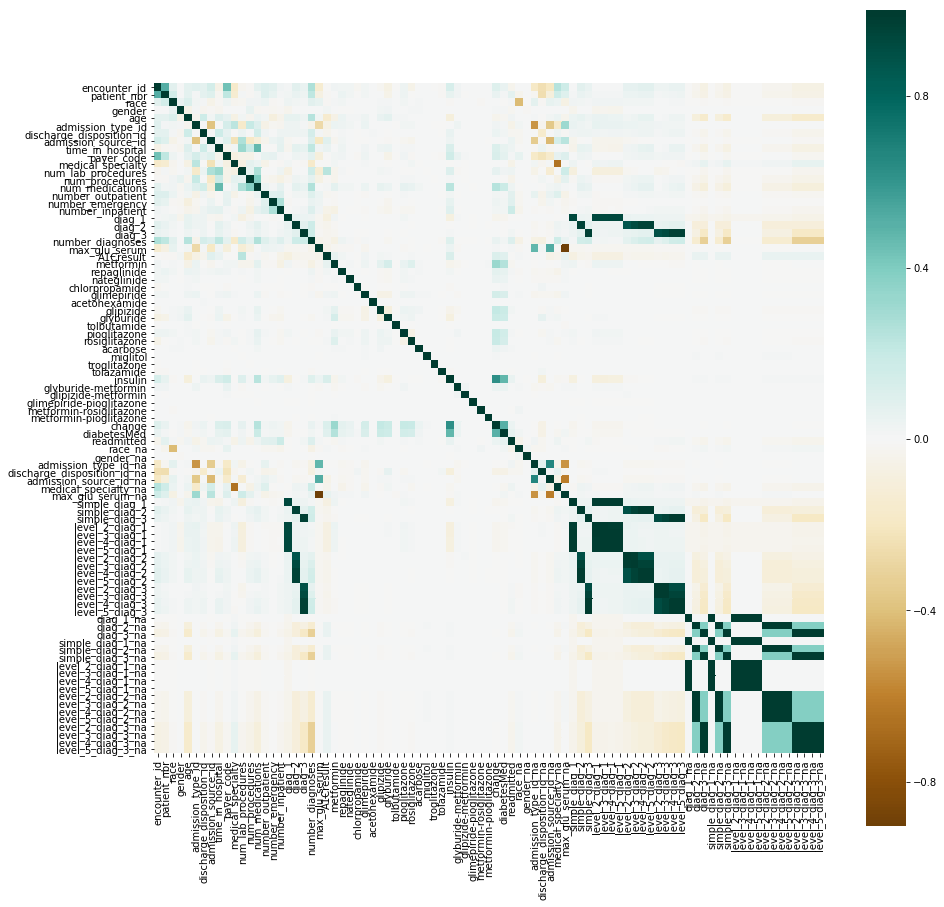

In [6]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        ax=ax,
        center=0,
        cmap='BrBG')

In [7]:
def frequencies_by_groups(df, groups, df_labels):
    by_groups = df[groups].groupby(groups).size()
    by_groups.name = 'value_count'
    by_groups = by_groups.reset_index()
    by_group1_sum = df[groups].groupby(groups[0]).size()
    by_group1_sum.name = 'sum_by_{}'.format(groups[0])
    by_group1_sum = by_group1_sum.reset_index()
    by_groups_merged = by_groups.merge(by_group1_sum)
    by_groups_merged['frequency'] = by_groups_merged.value_count.divide(by_groups_merged['sum_by_{}'.format(groups[0])])
    by_groups_merged.readmitted = by_groups_merged.readmitted.map(dict(zip(range(len(df_labels['readmitted'])), df_labels['readmitted'])))
    if groups[0] in df_labels.keys():
        by_groups_merged[groups[0]] = by_groups_merged[groups[0]].map(dict(zip(range(len(df_labels[groups[0]])), df_labels[groups[0]])))
    return by_groups_merged

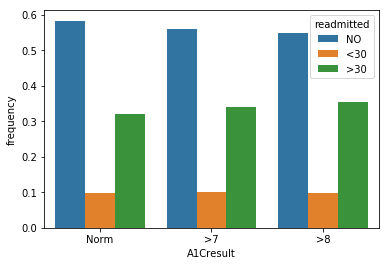

In [8]:
by_A1Cresult = frequencies_by_groups(df, ['A1Cresult', 'readmitted'], df_labels)
sns.barplot(x='A1Cresult', y='frequency', hue = 'readmitted', data=by_A1Cresult)

In [9]:
x_columns = [
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
 'race_na',
 'gender_na',
 'admission_type_id_na',
 'discharge_disposition_id_na',
 'admission_source_id_na',
 'medical_specialty_na',
 'diag_1_na',
 'diag_2_na',
 'diag_3_na'
]

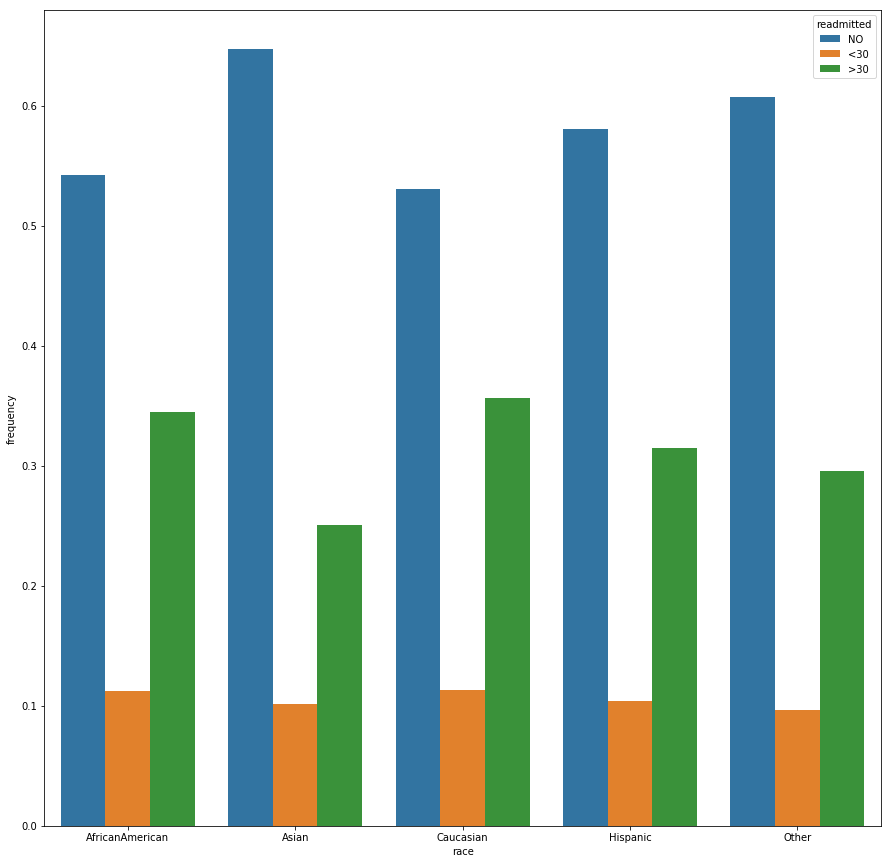

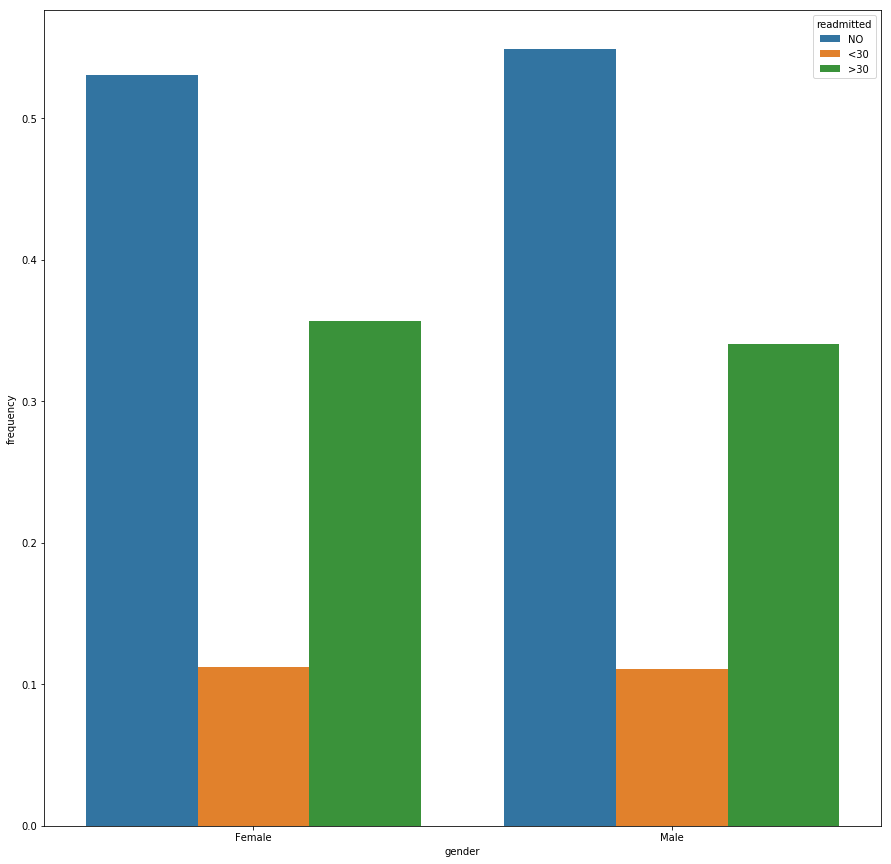

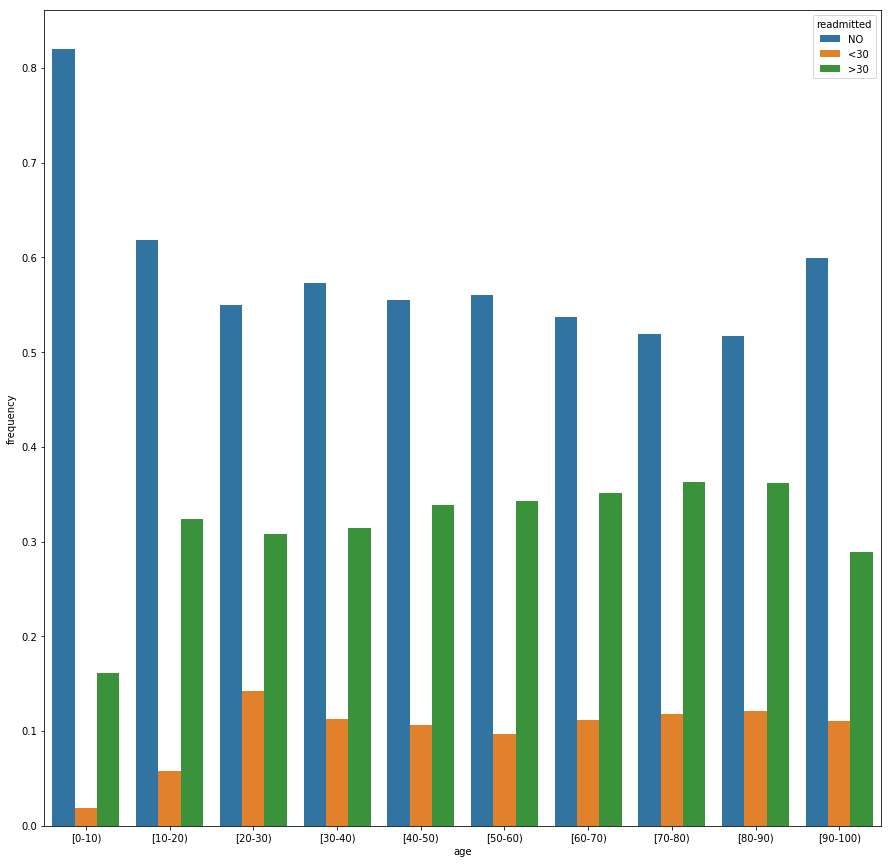

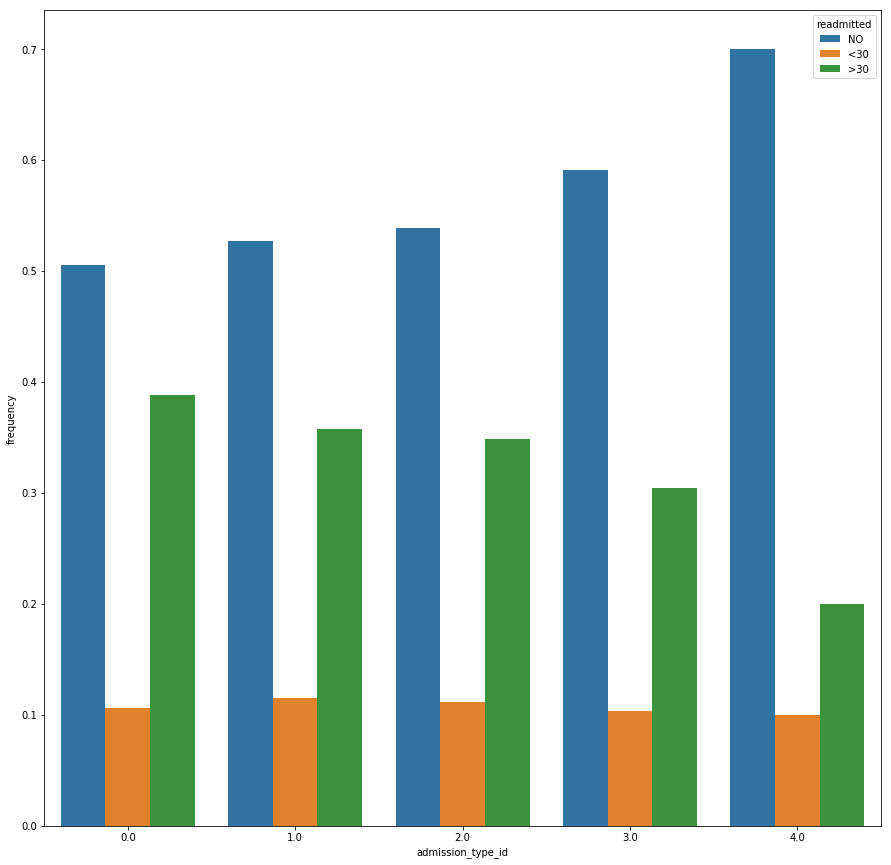

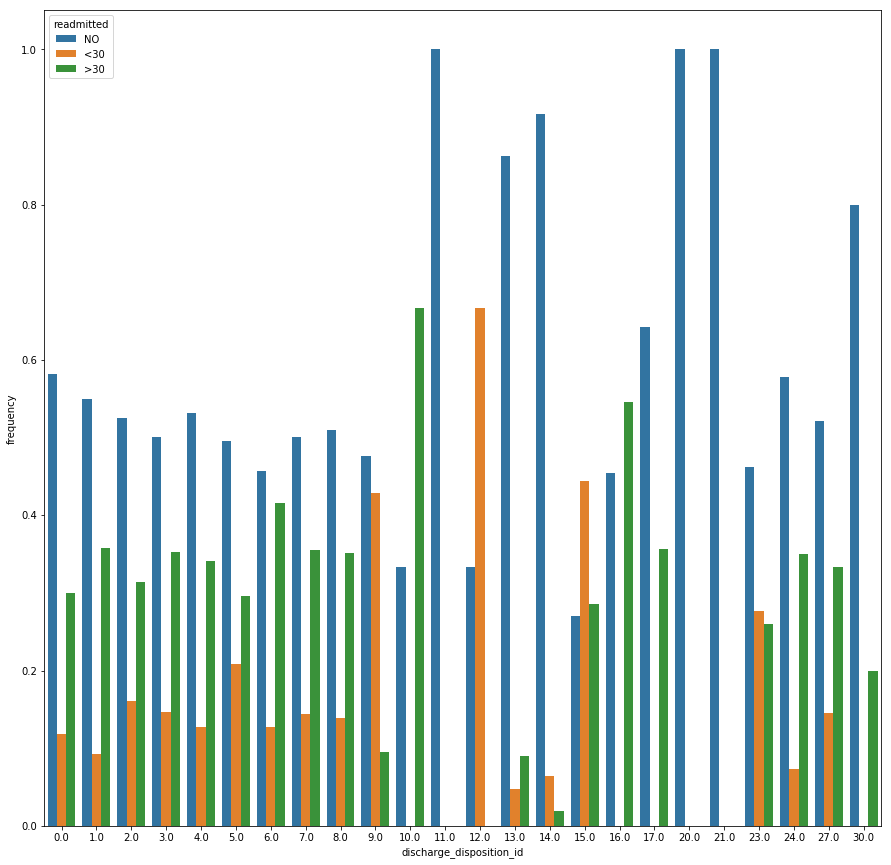

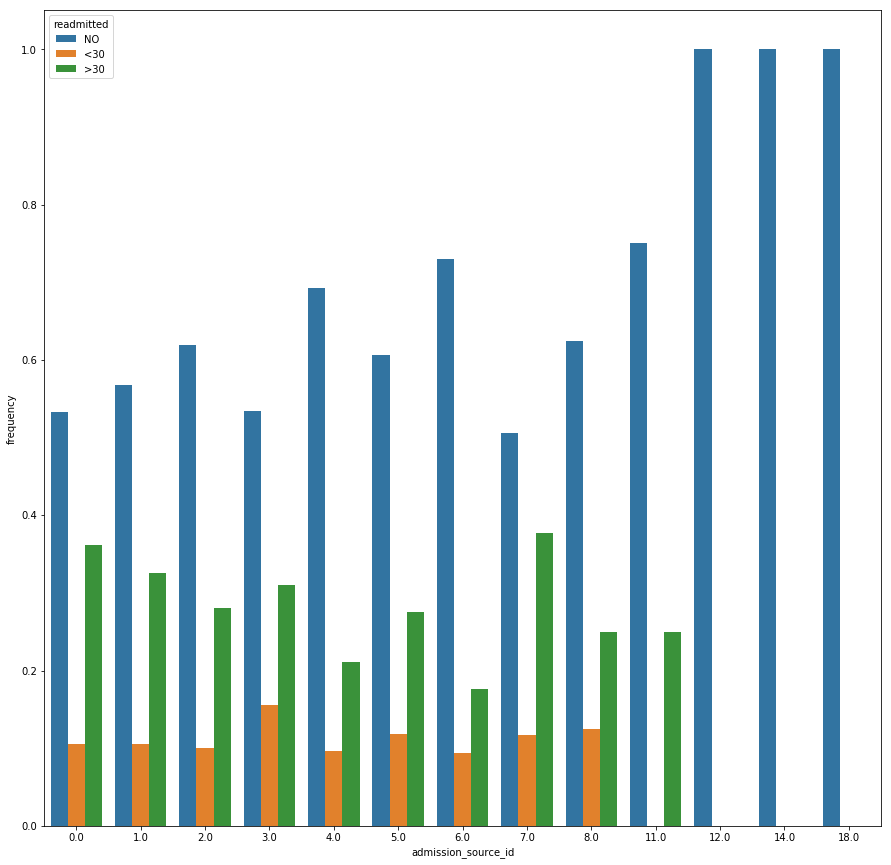

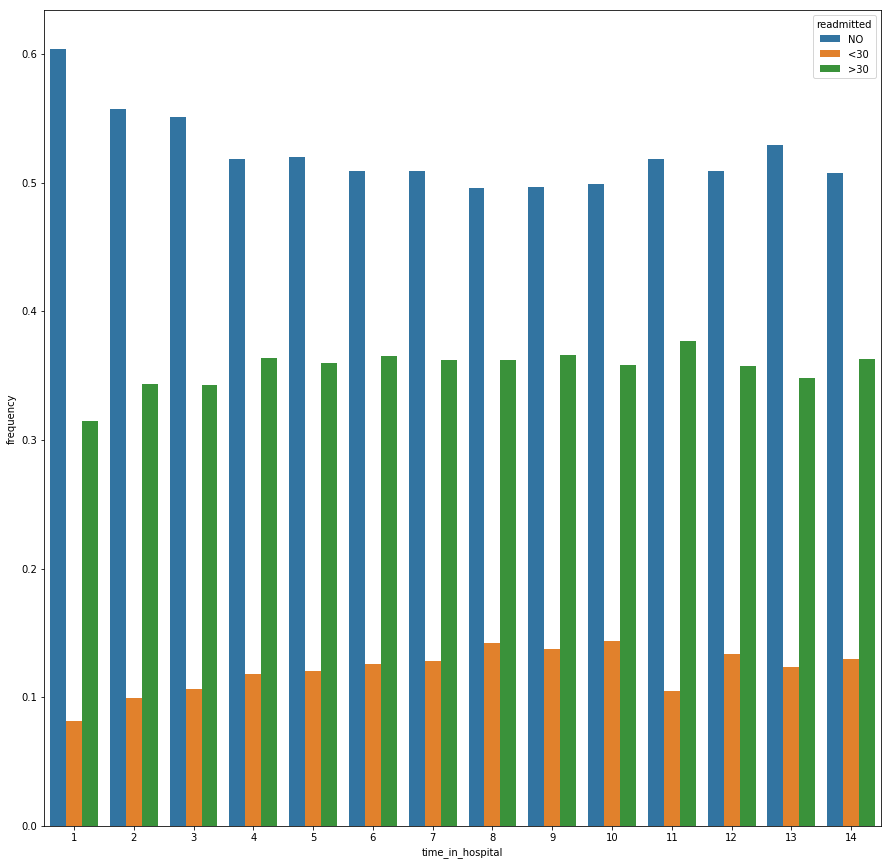

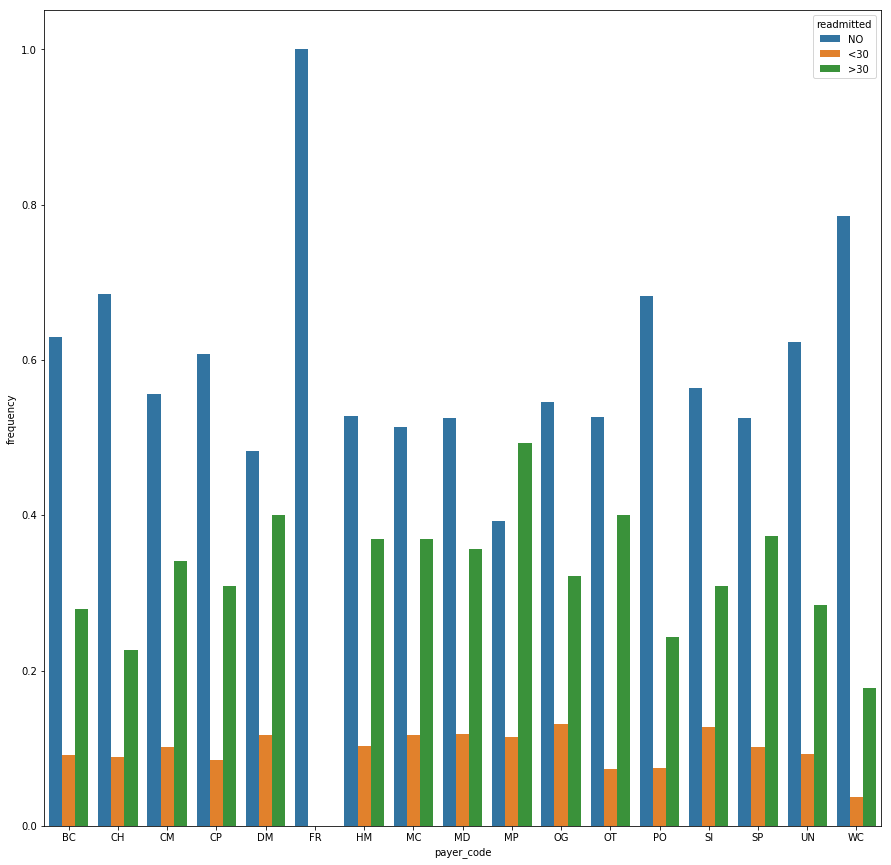

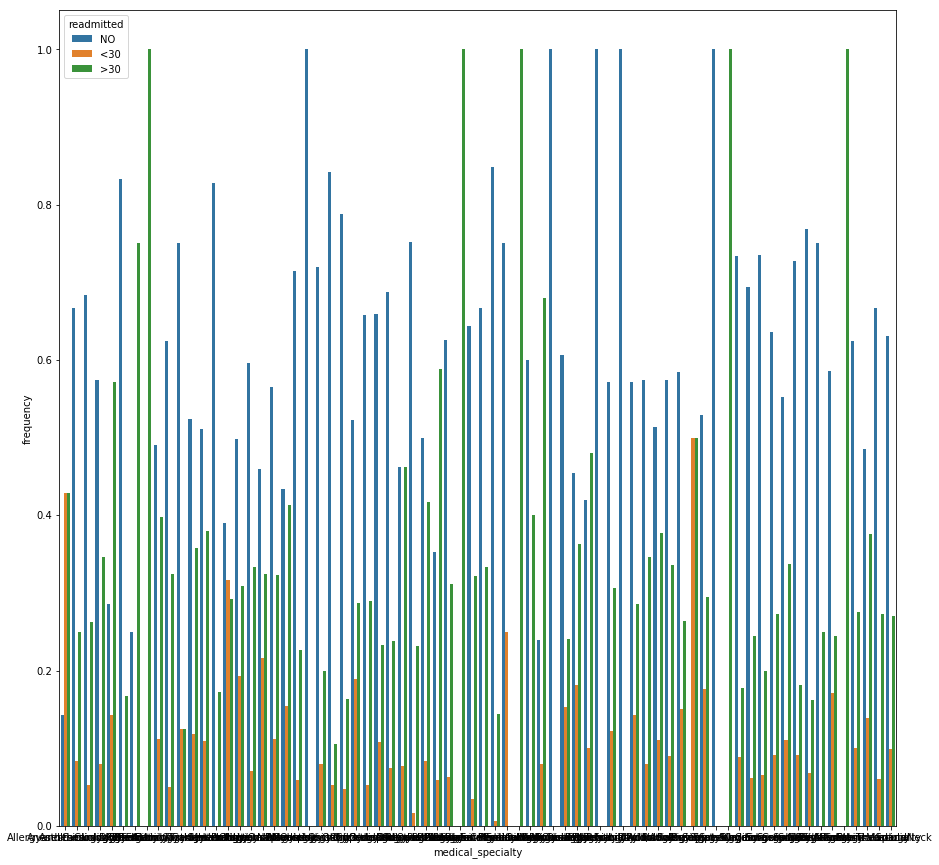

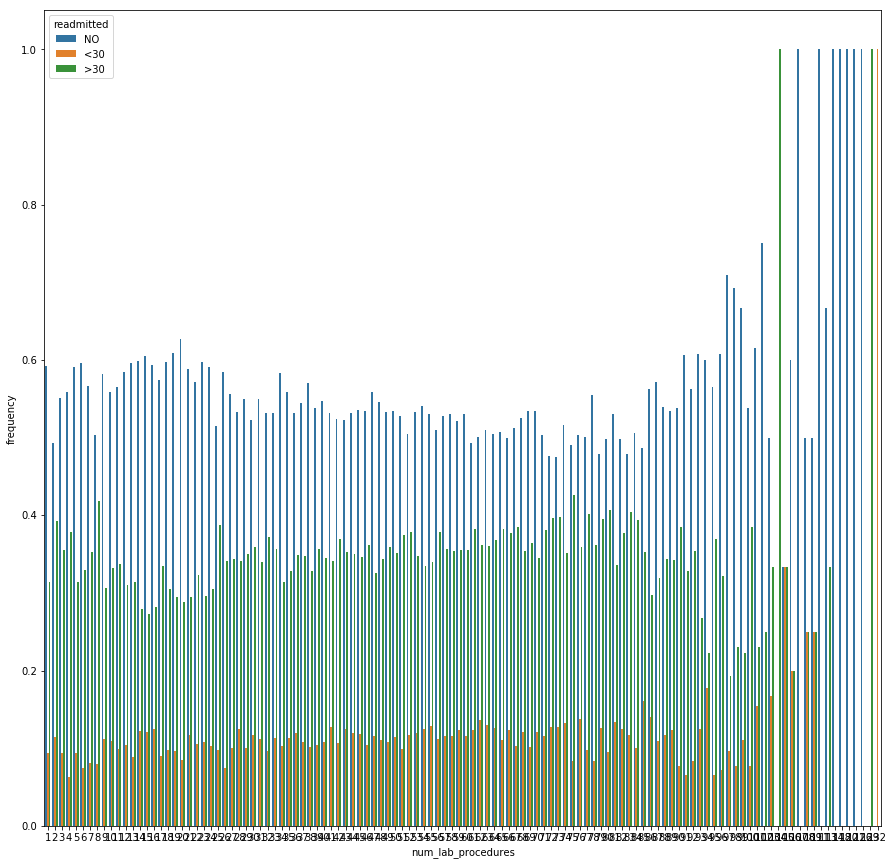

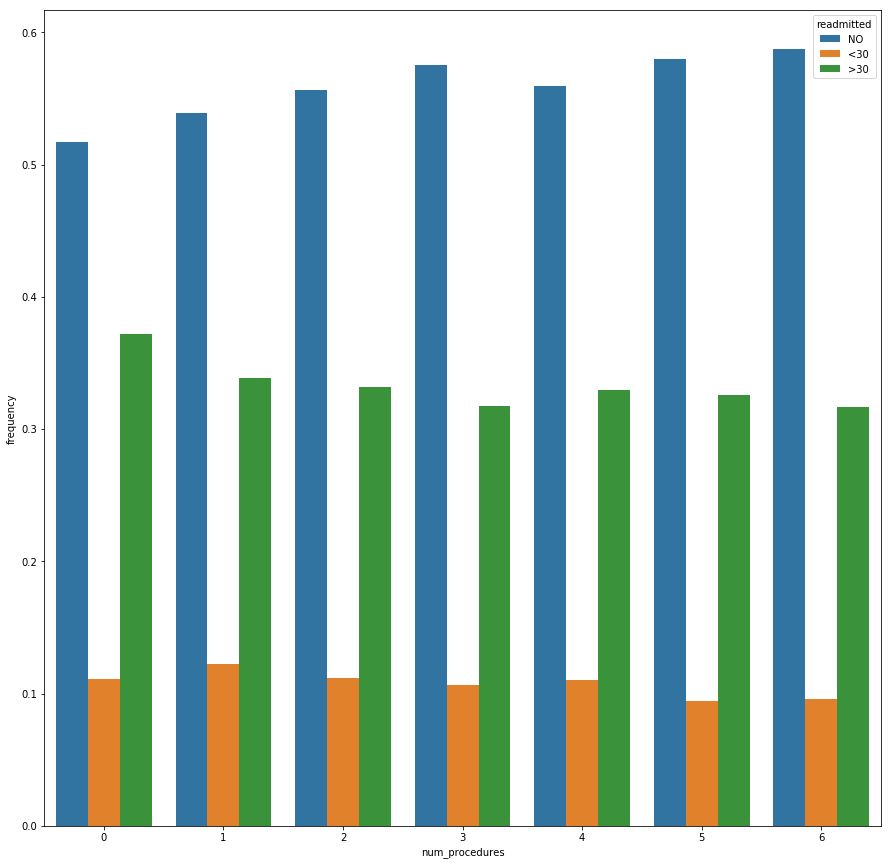

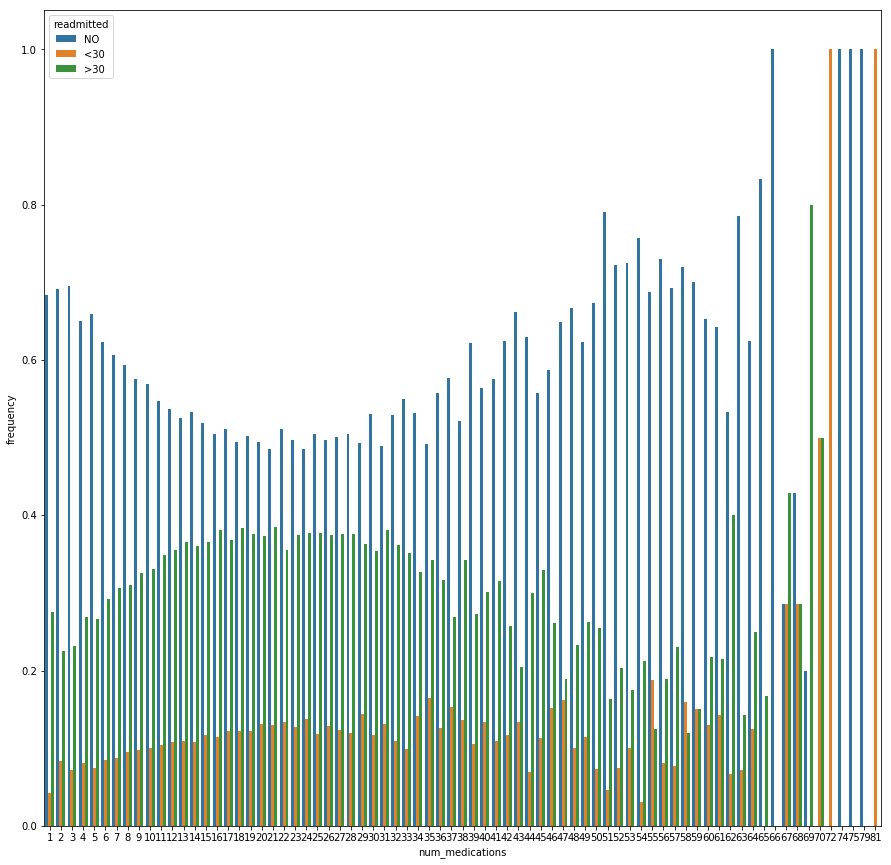

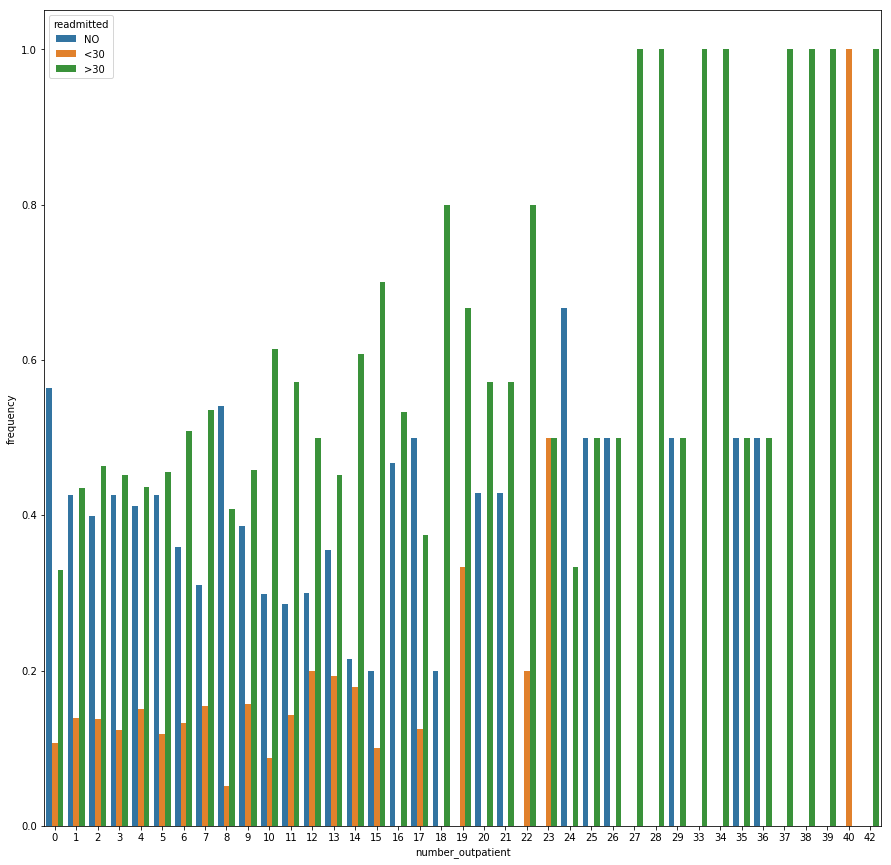

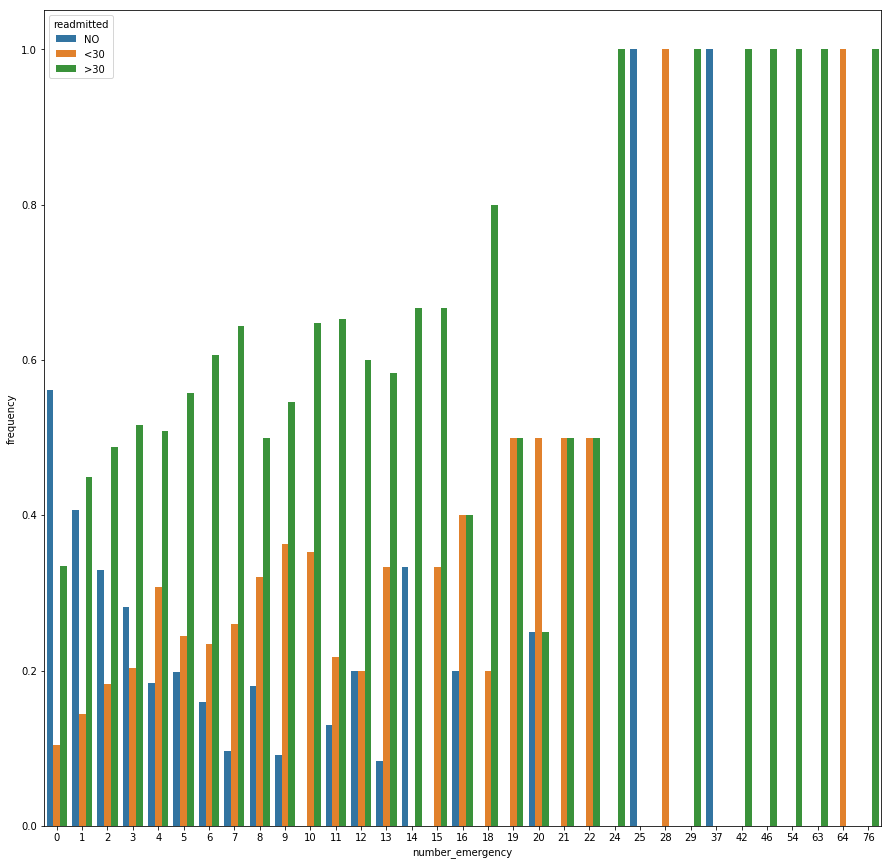

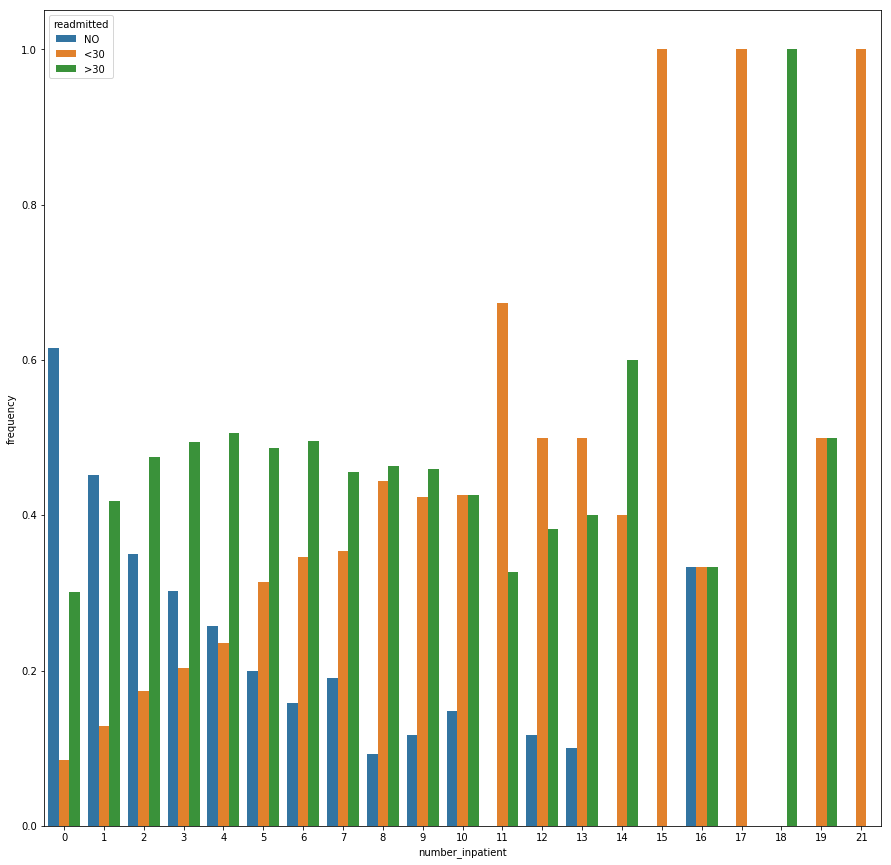

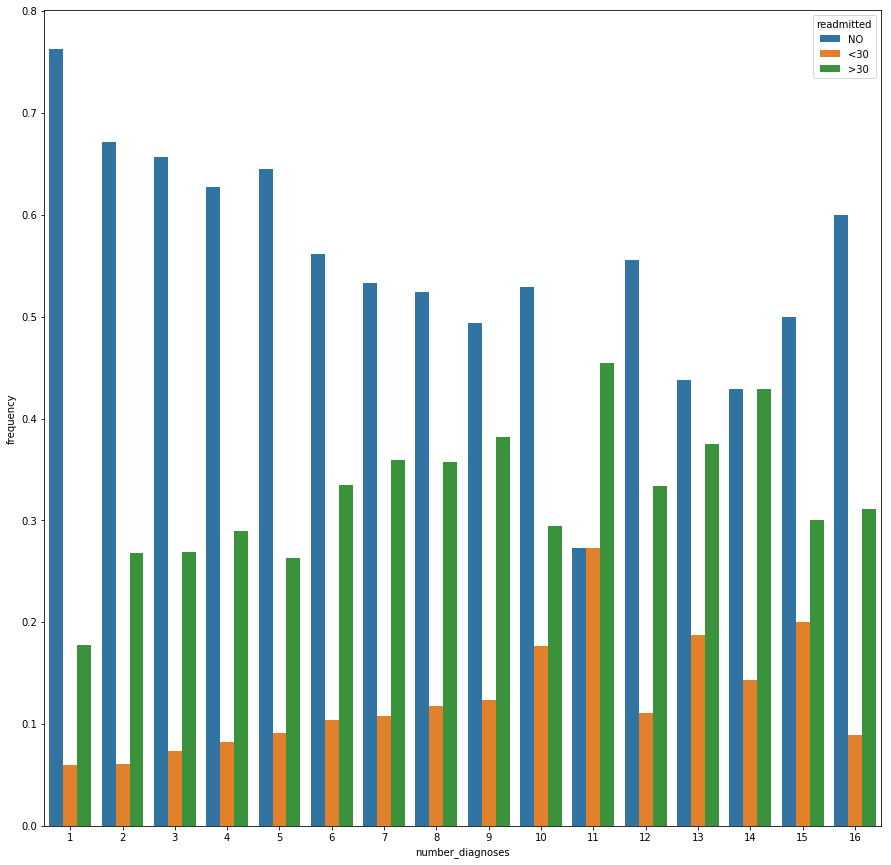

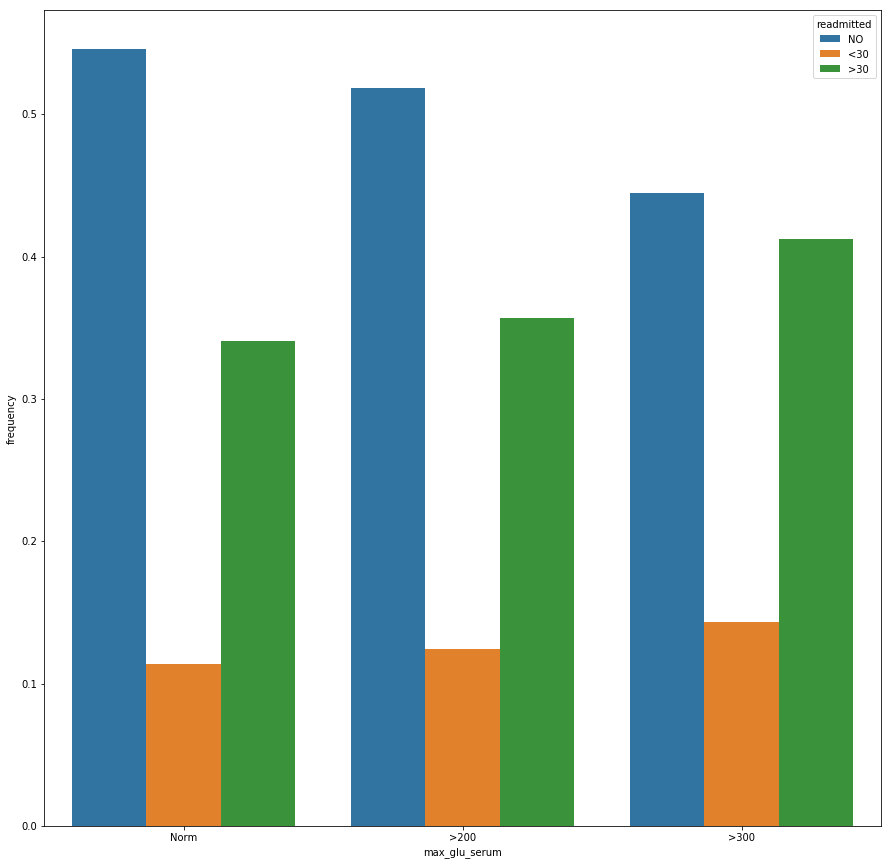

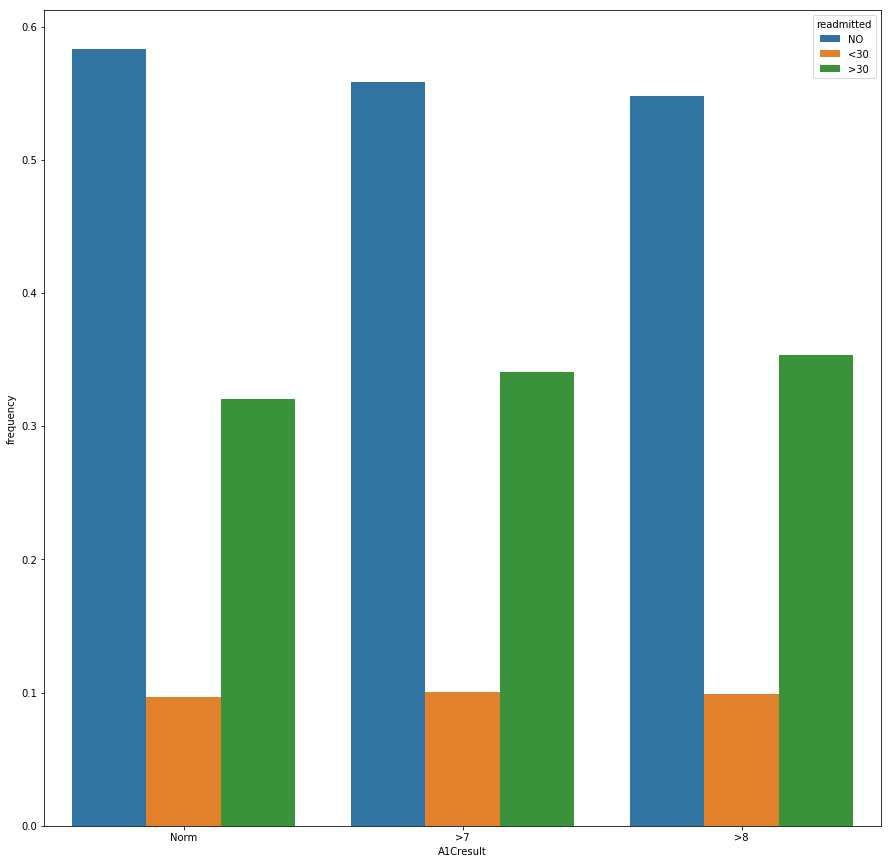

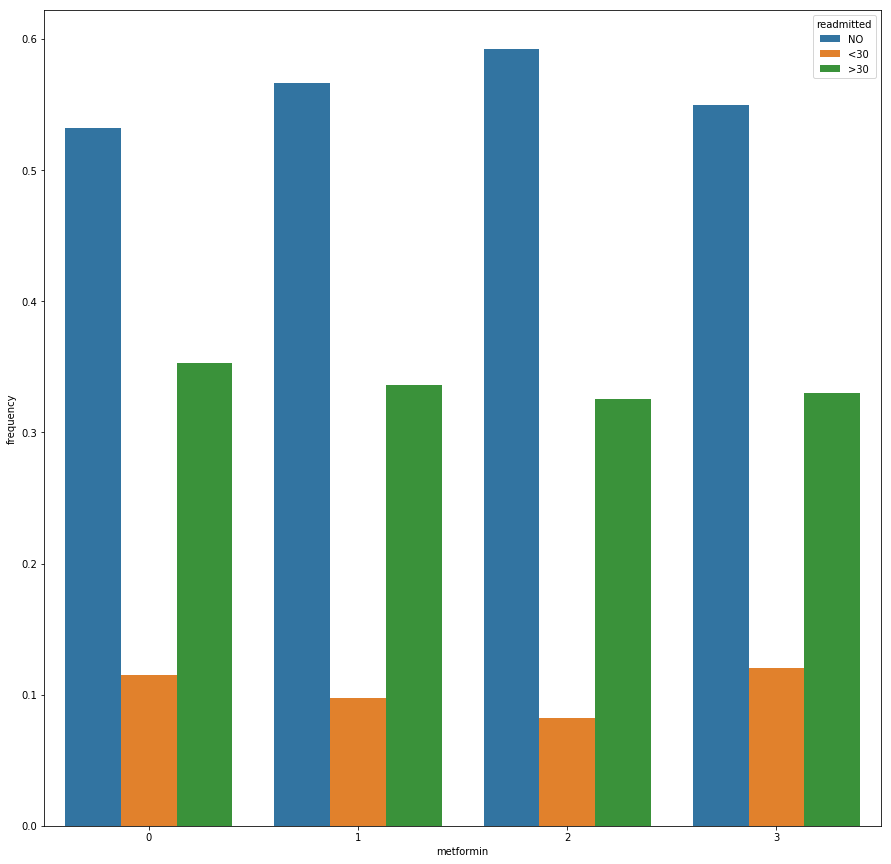

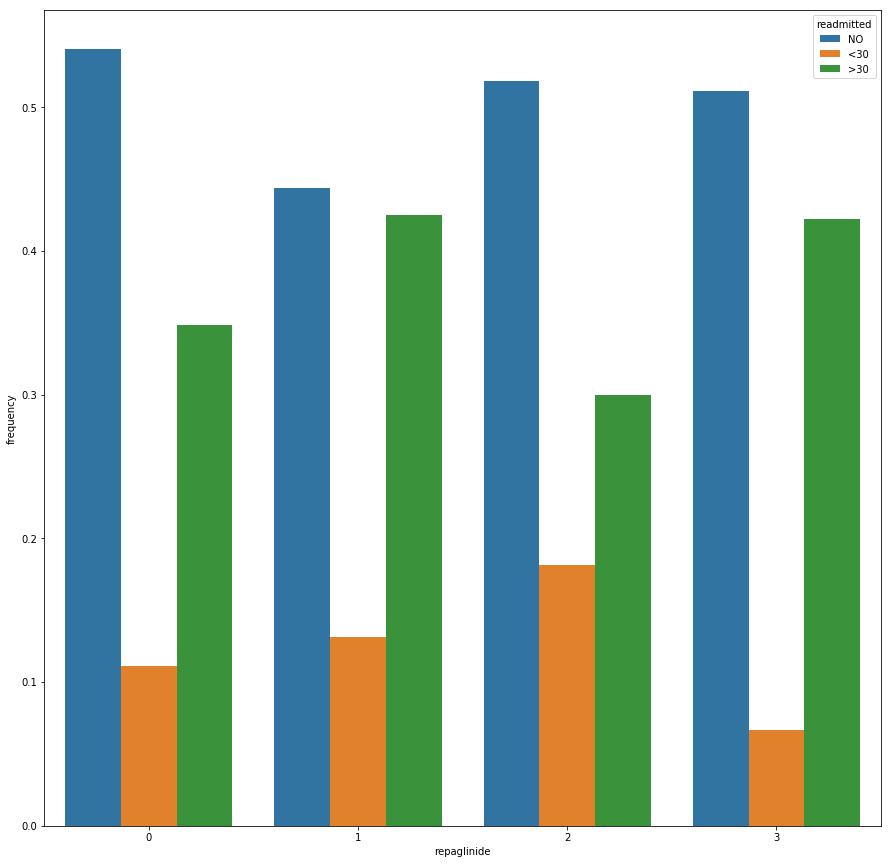

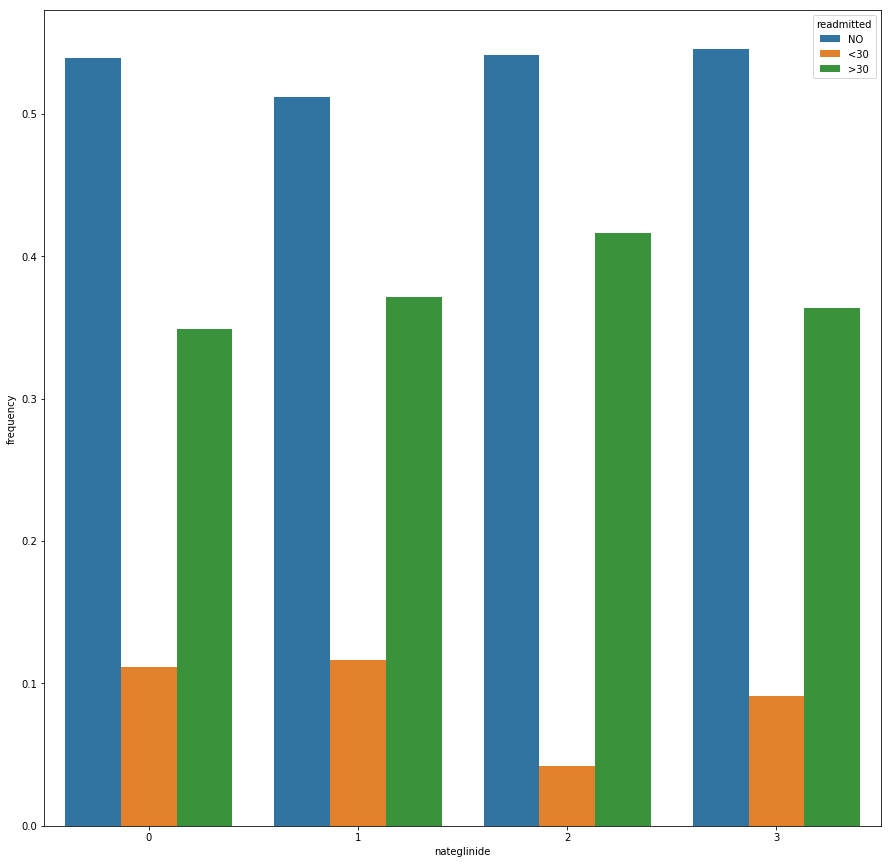

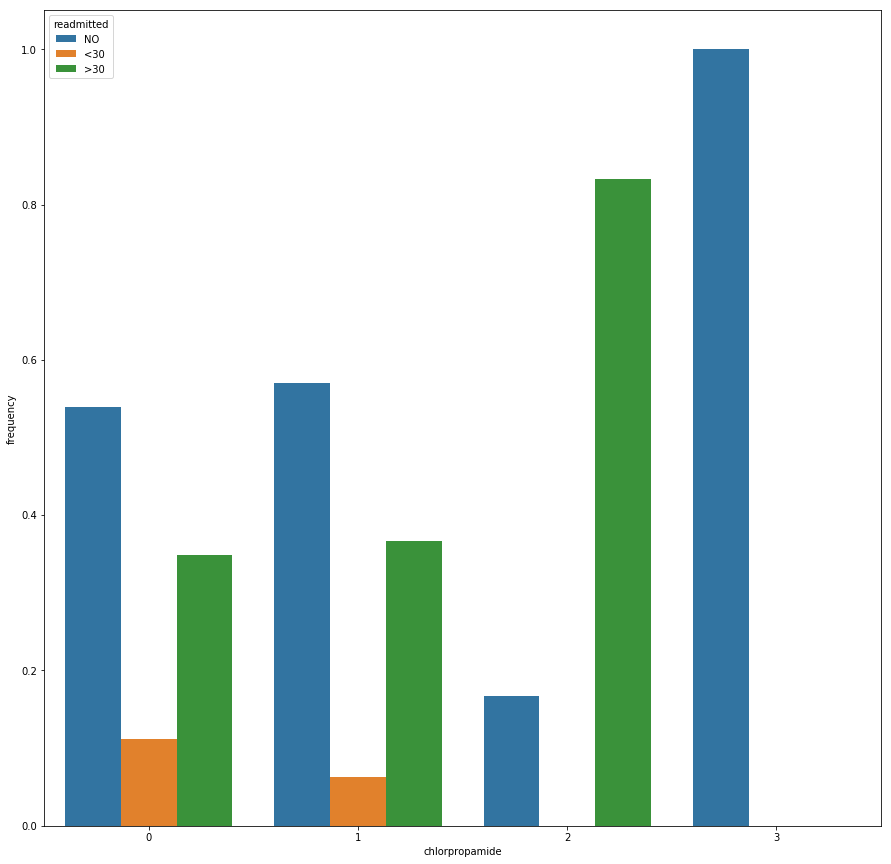

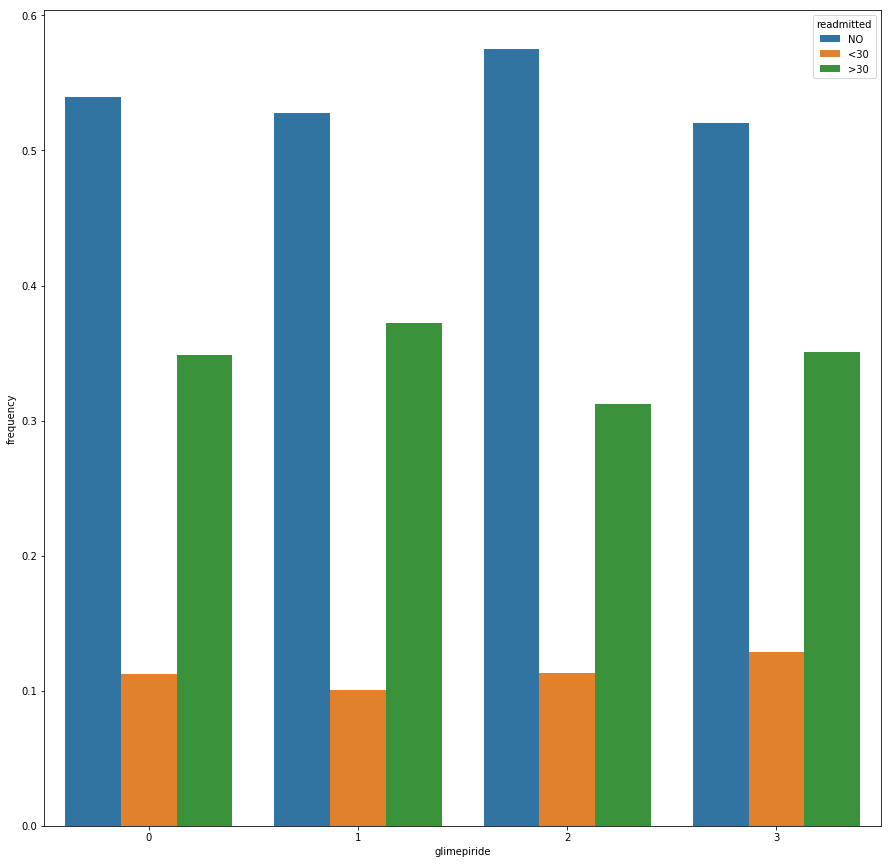

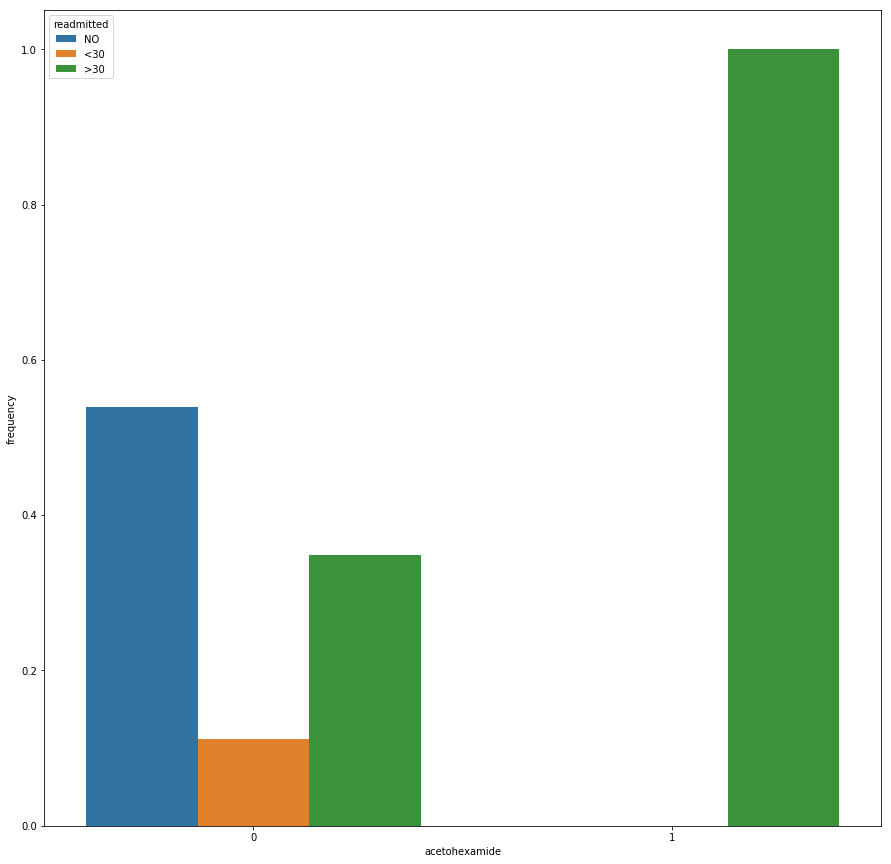

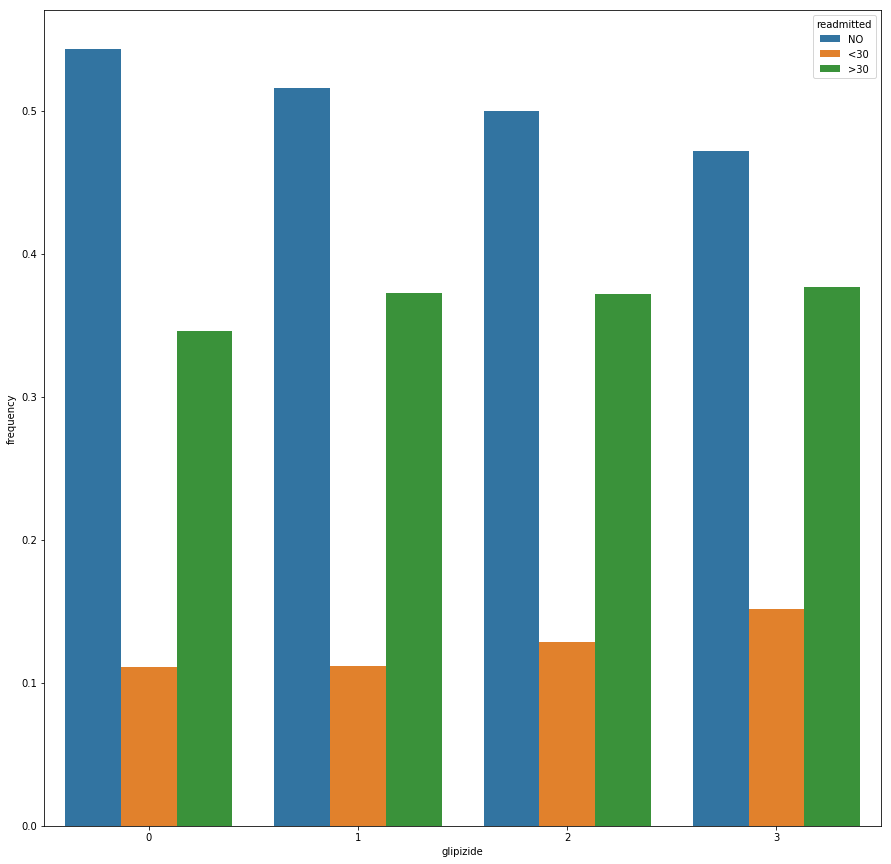

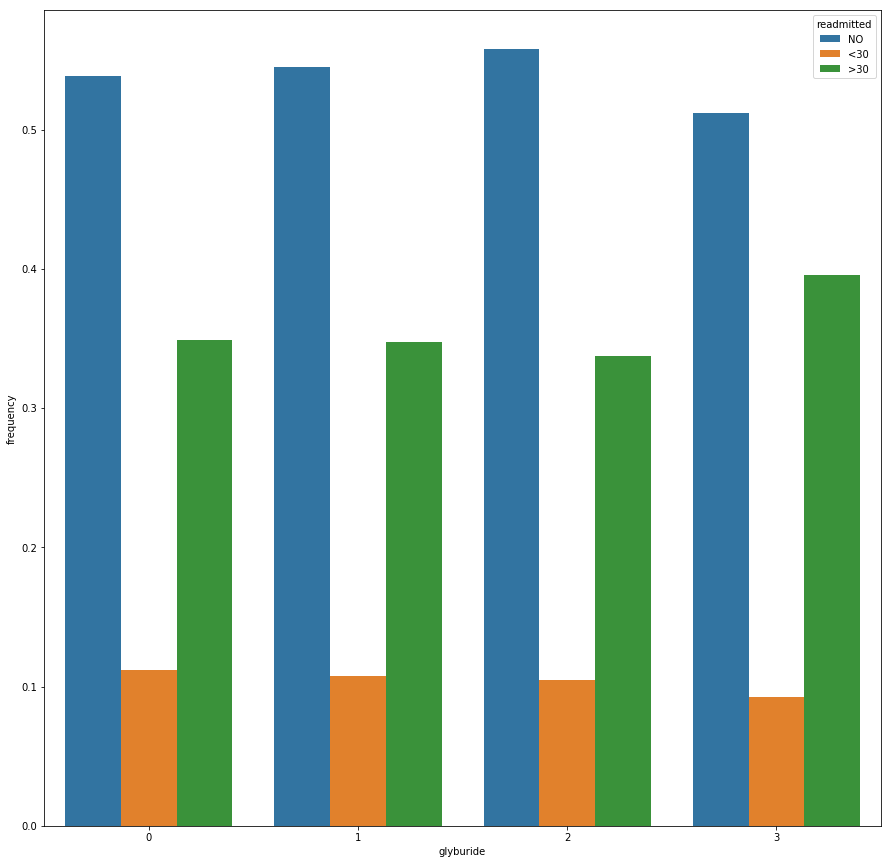

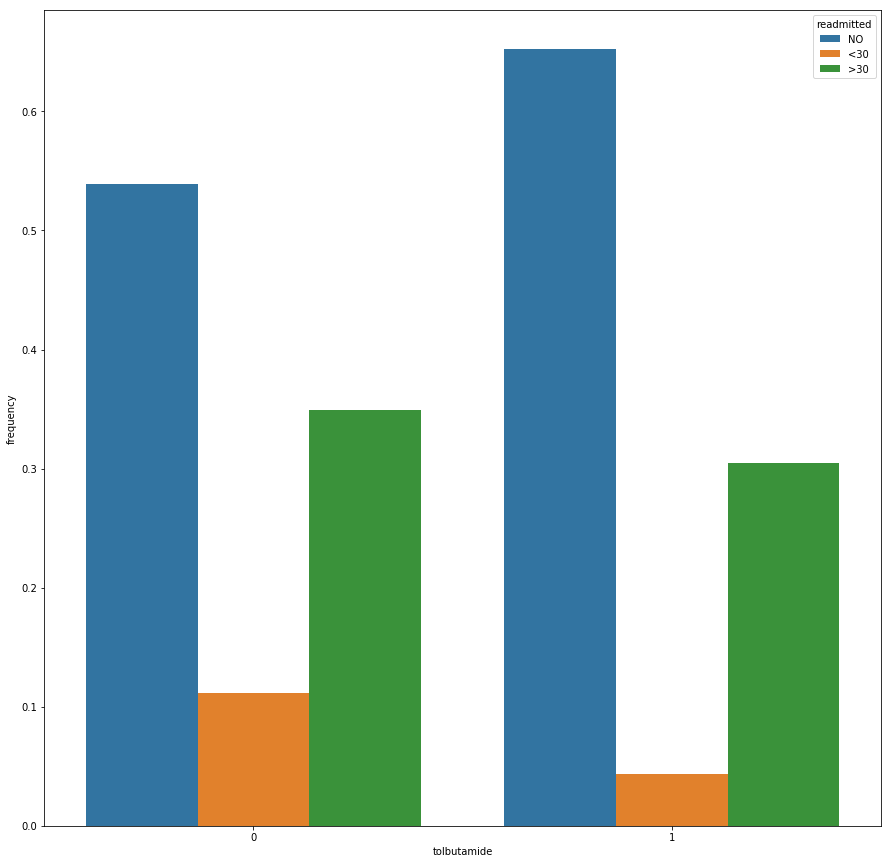

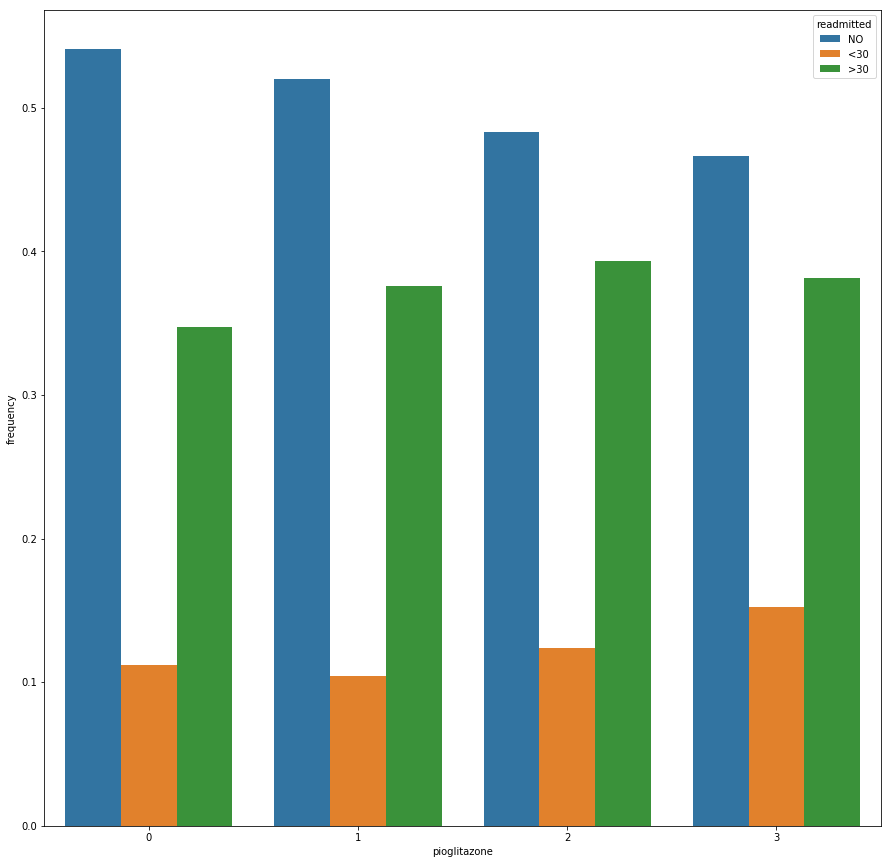

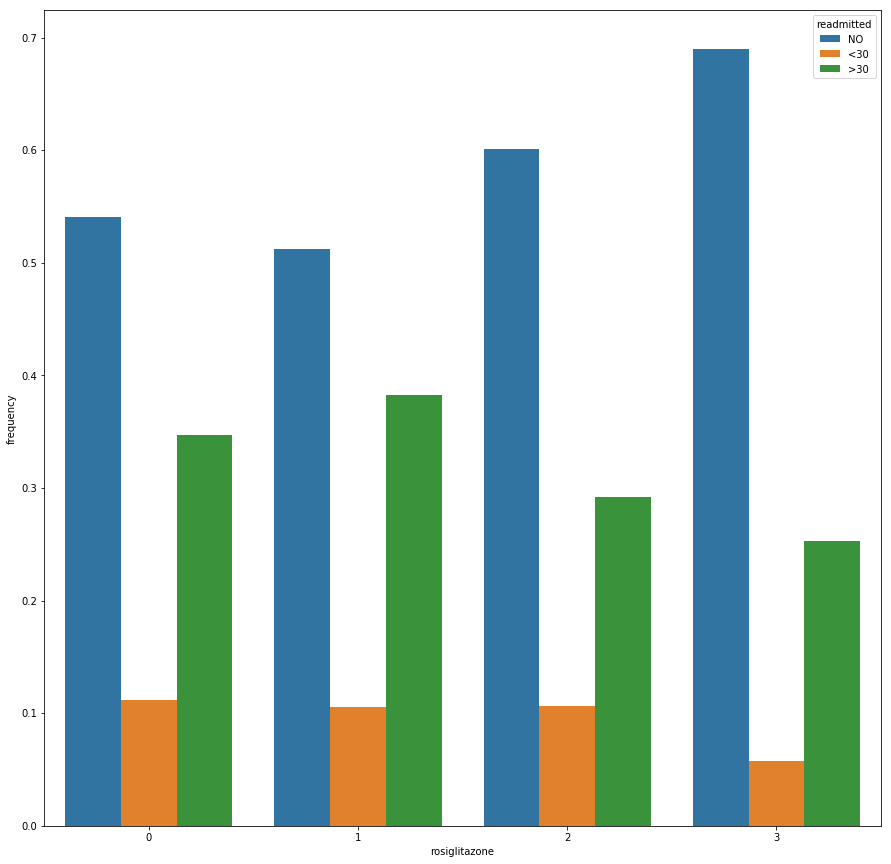

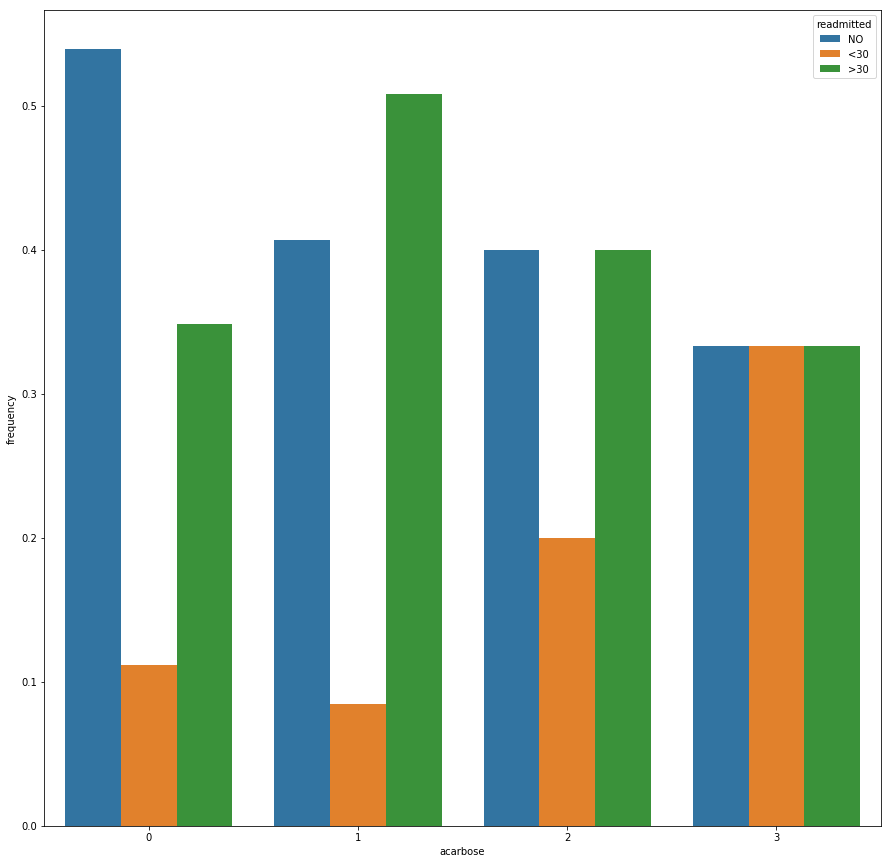

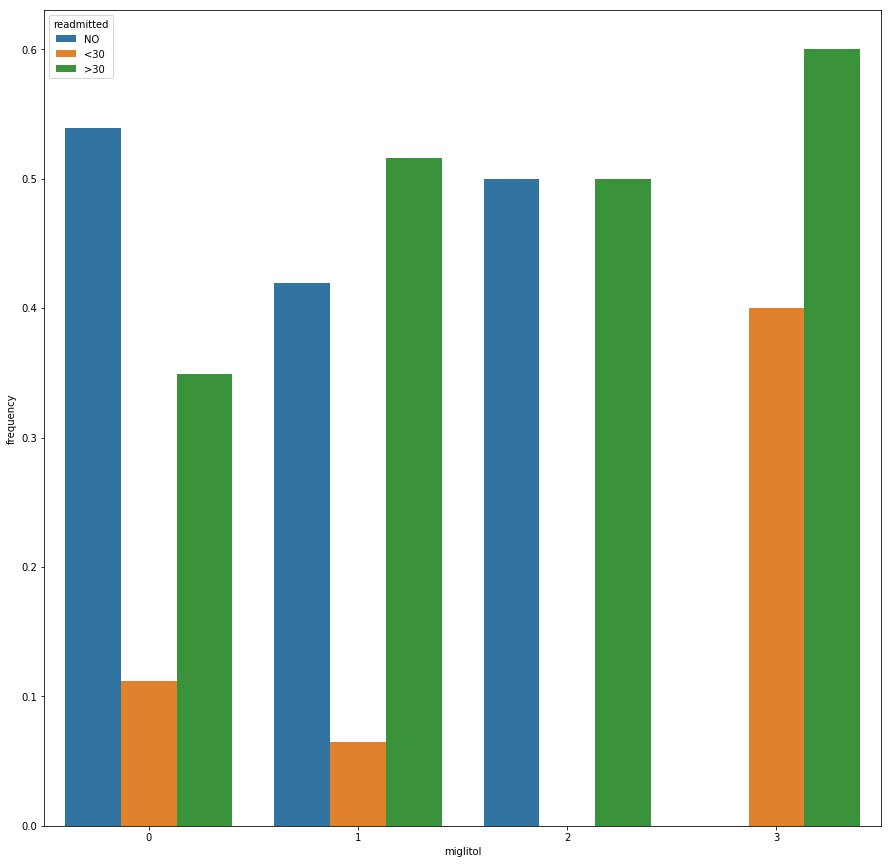

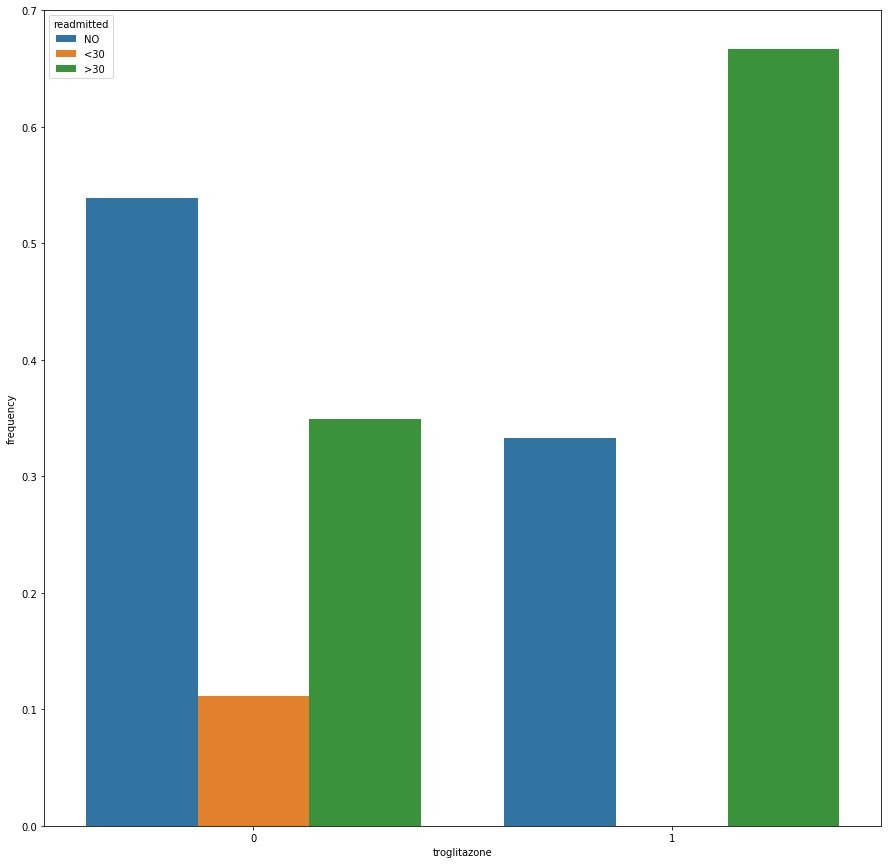

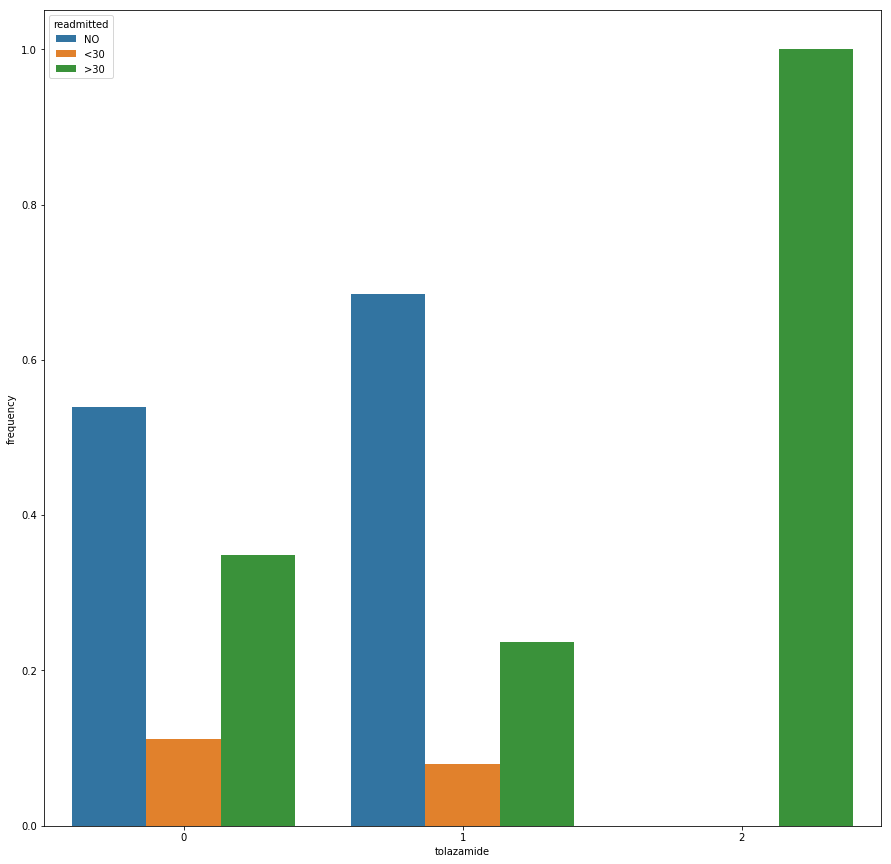

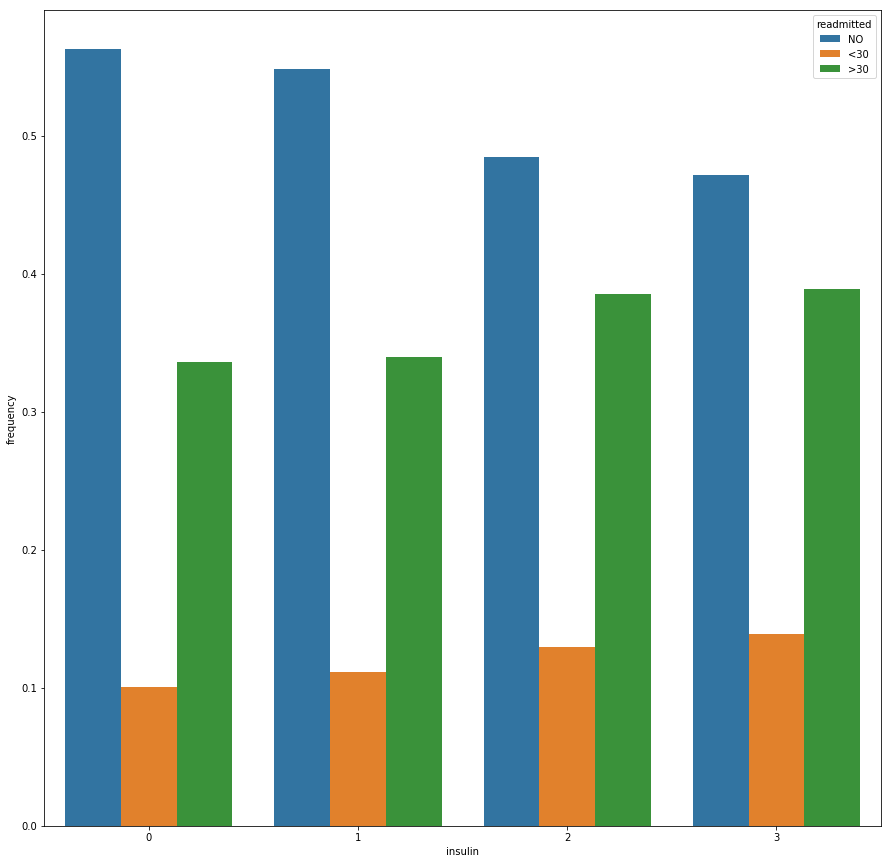

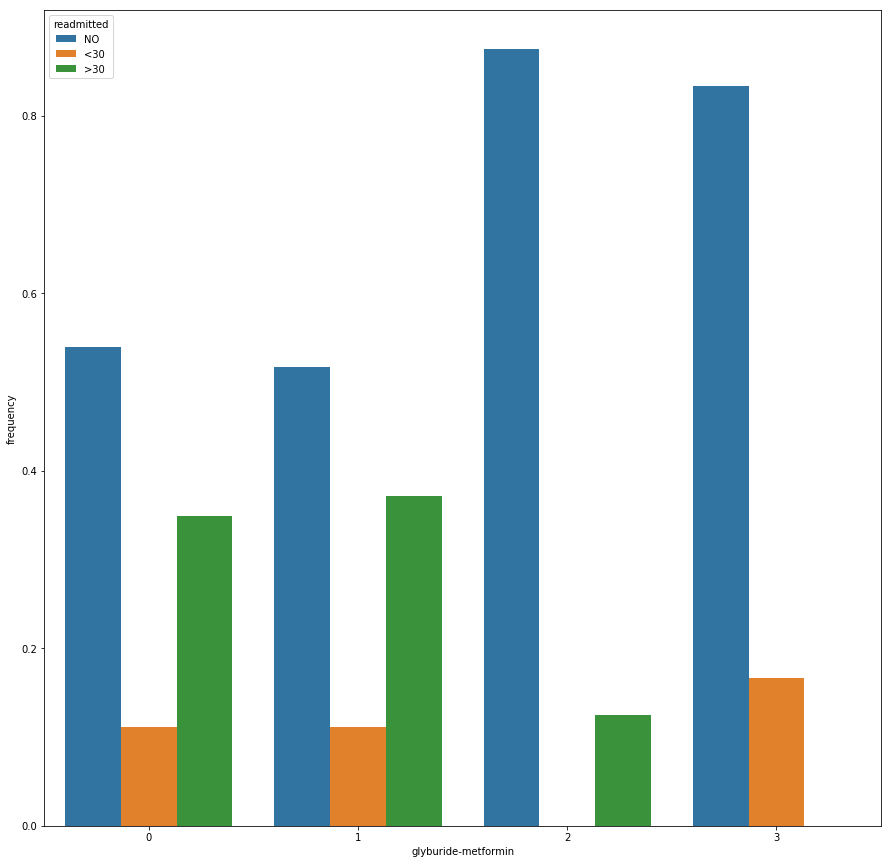

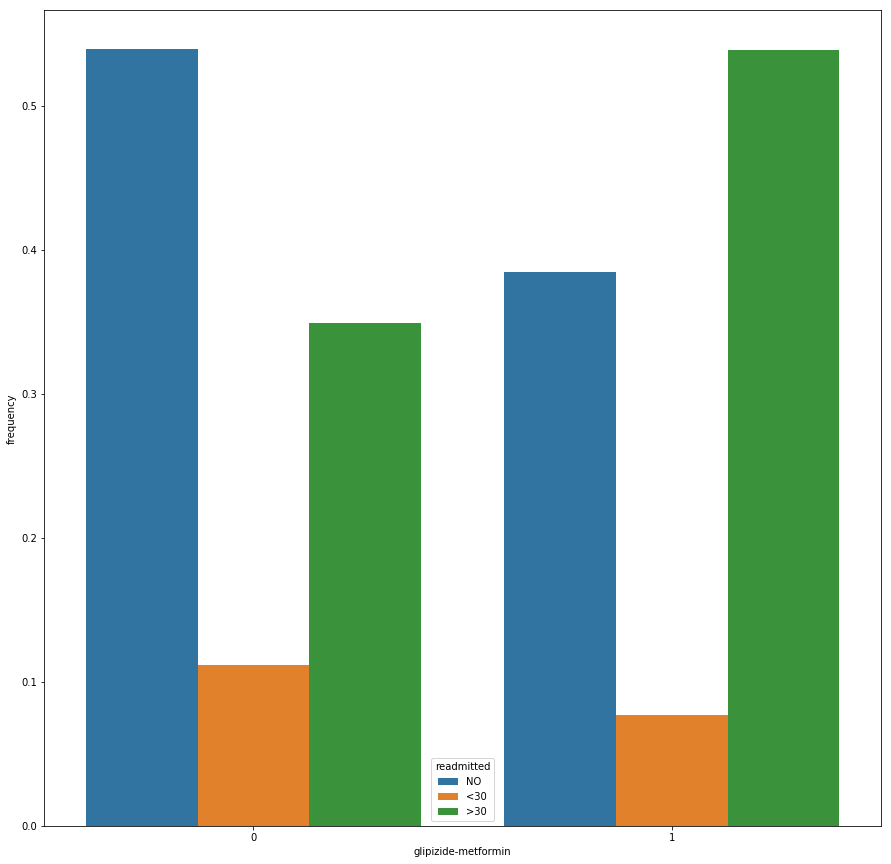

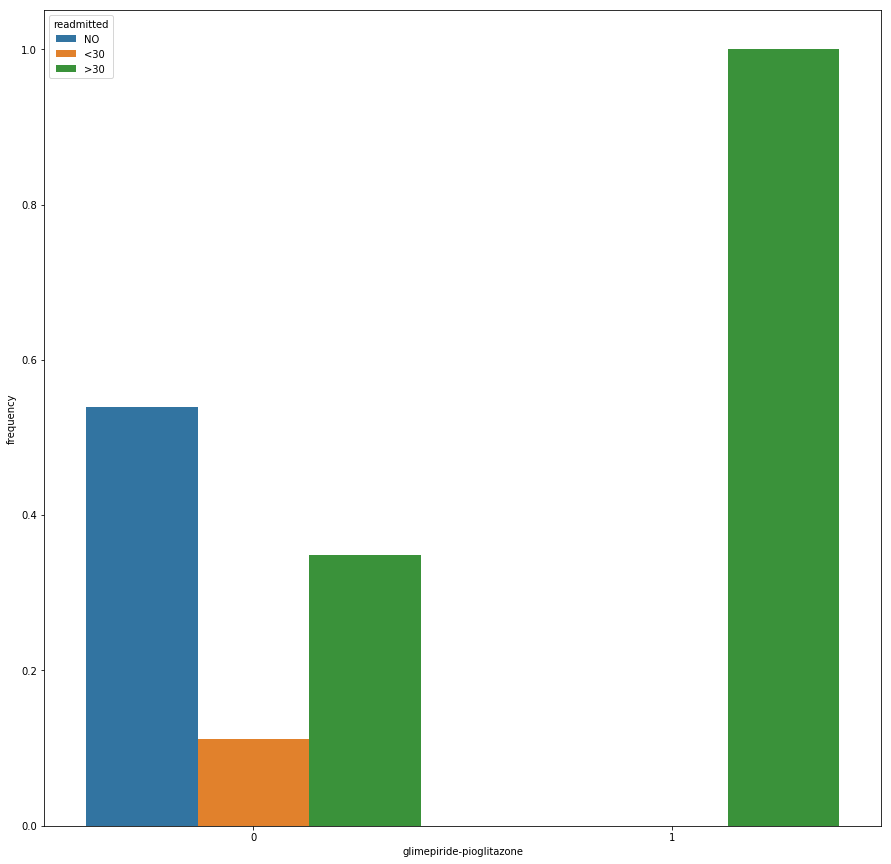

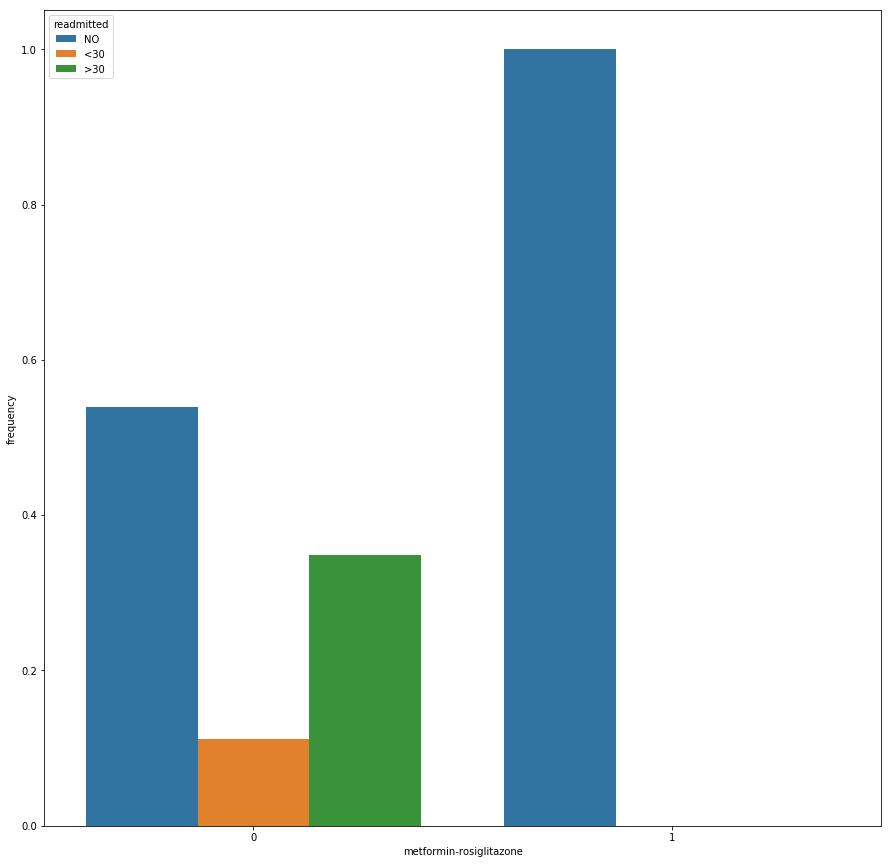

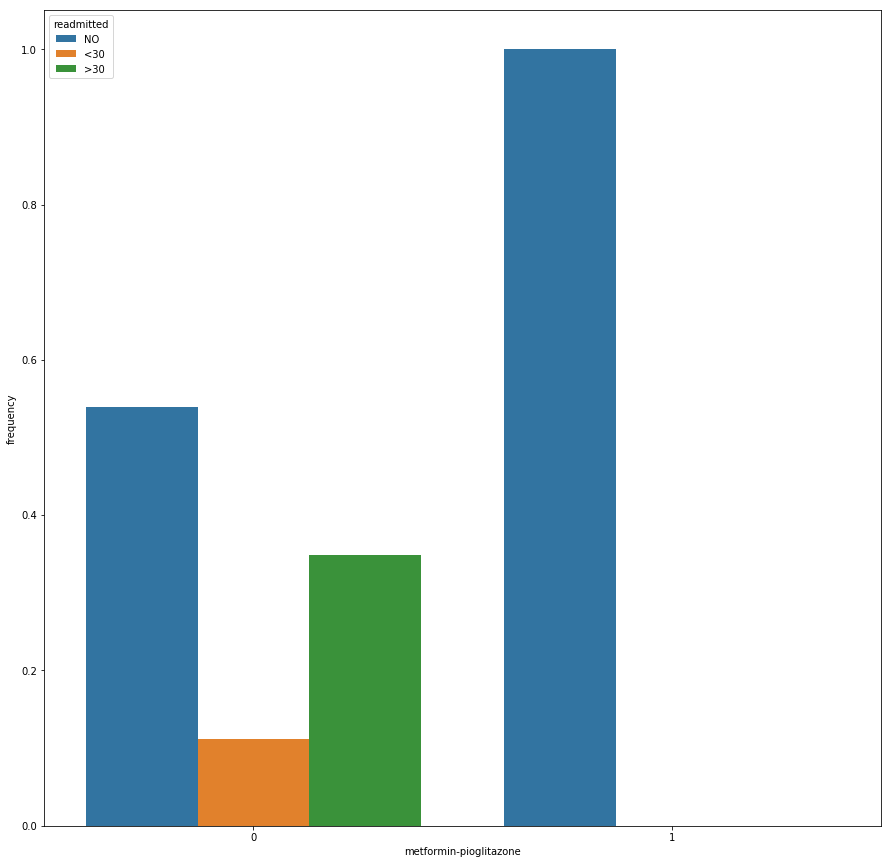

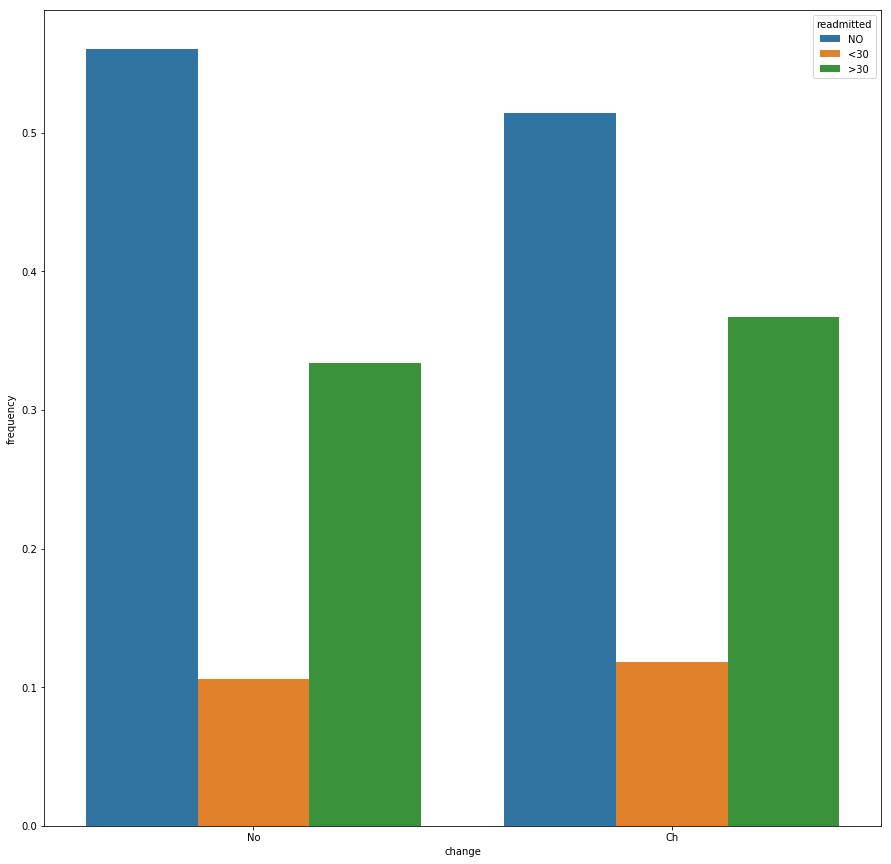

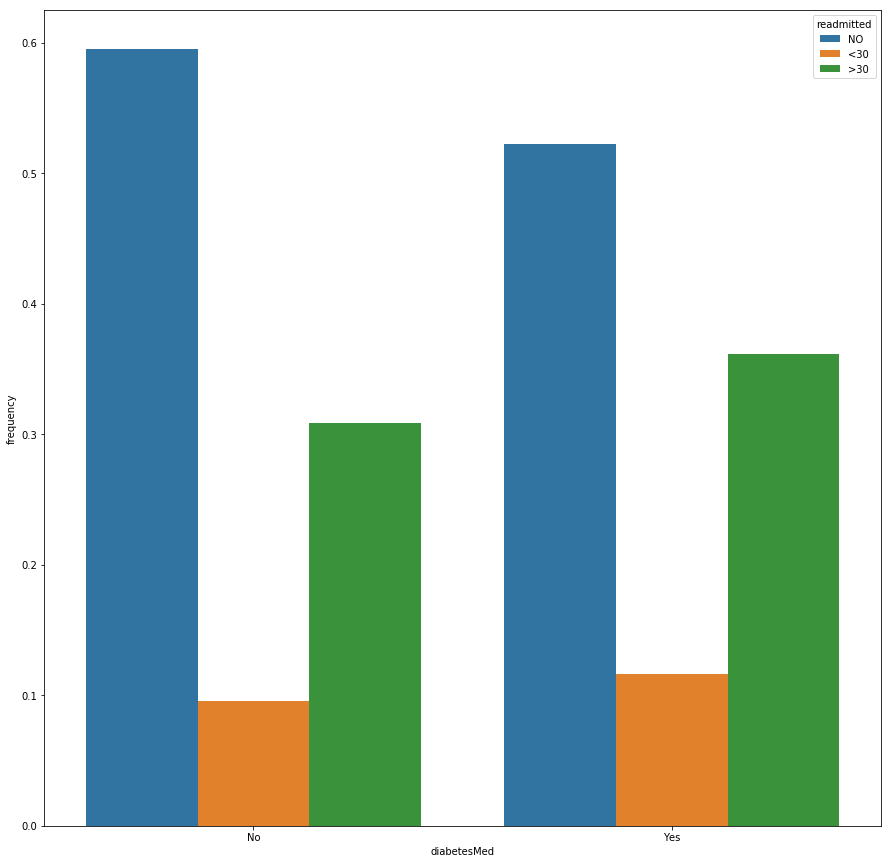

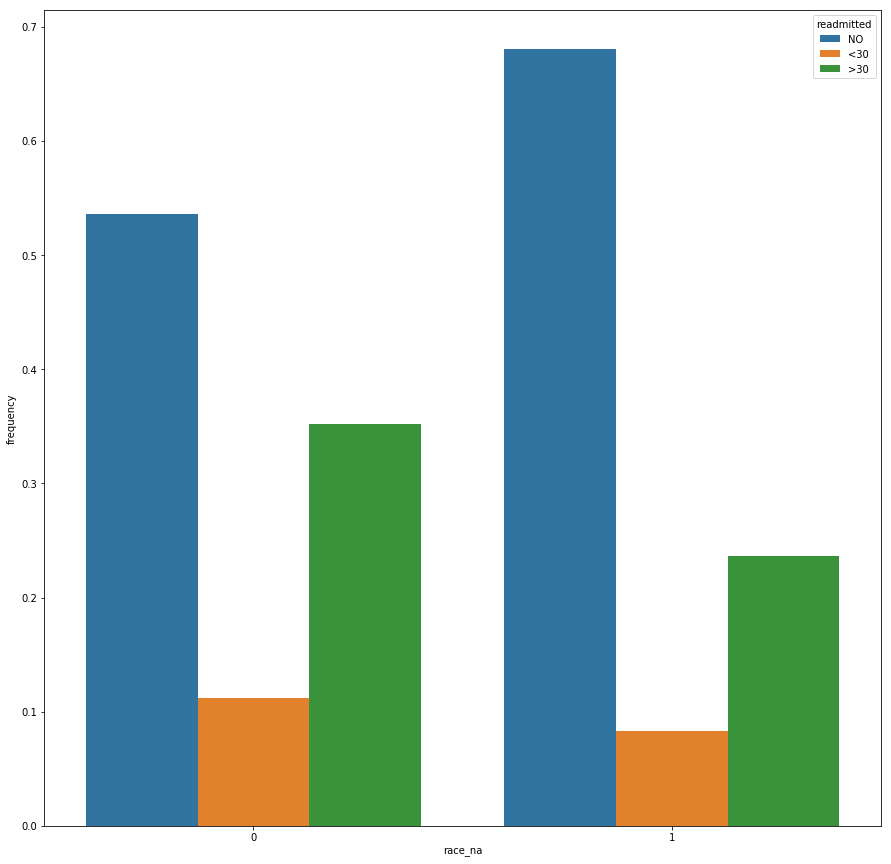

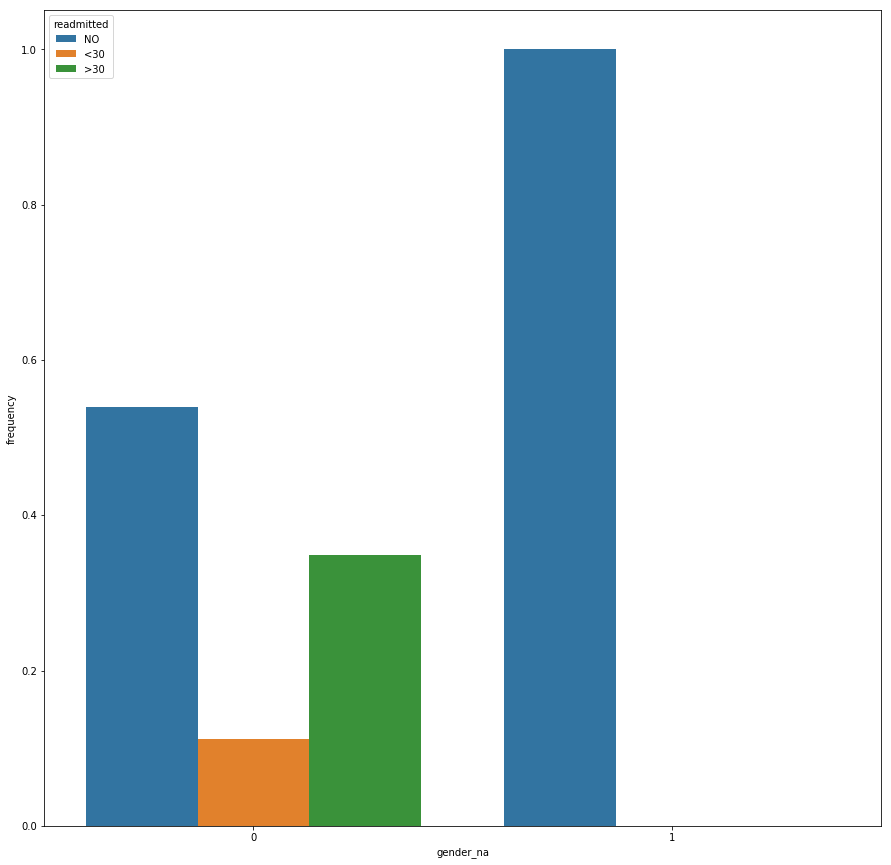

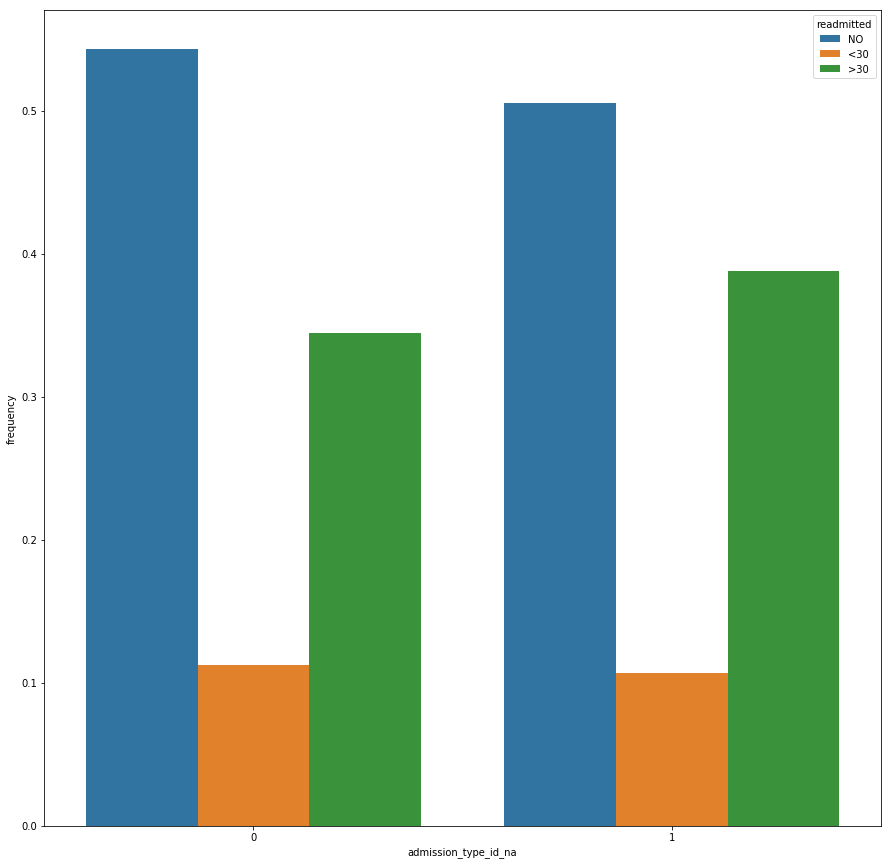

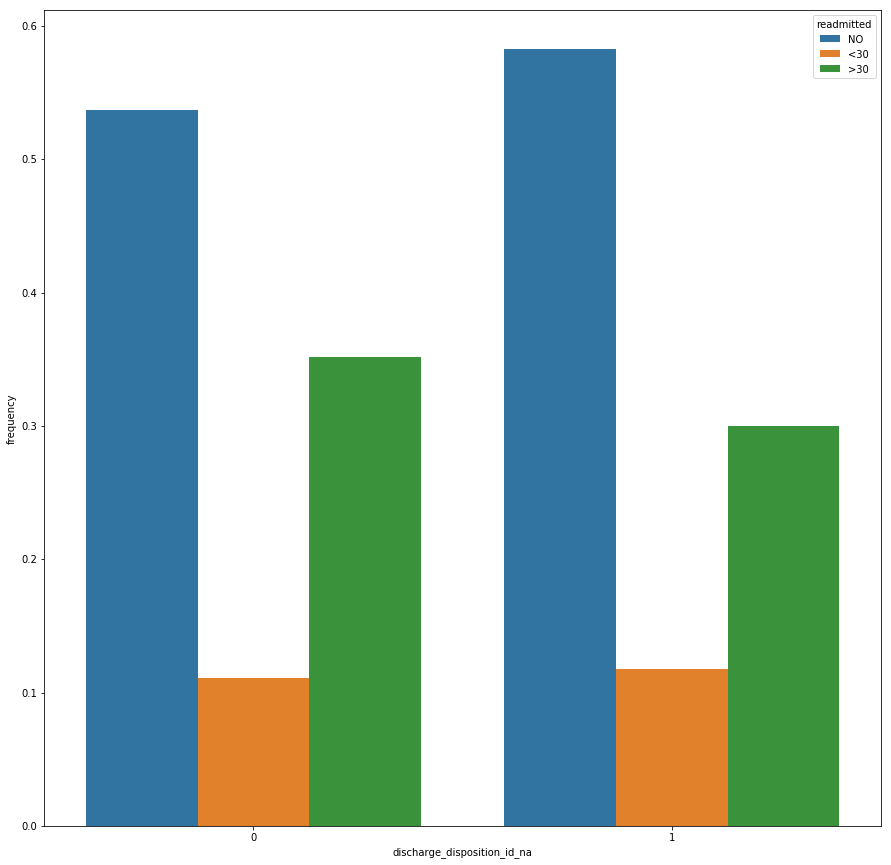

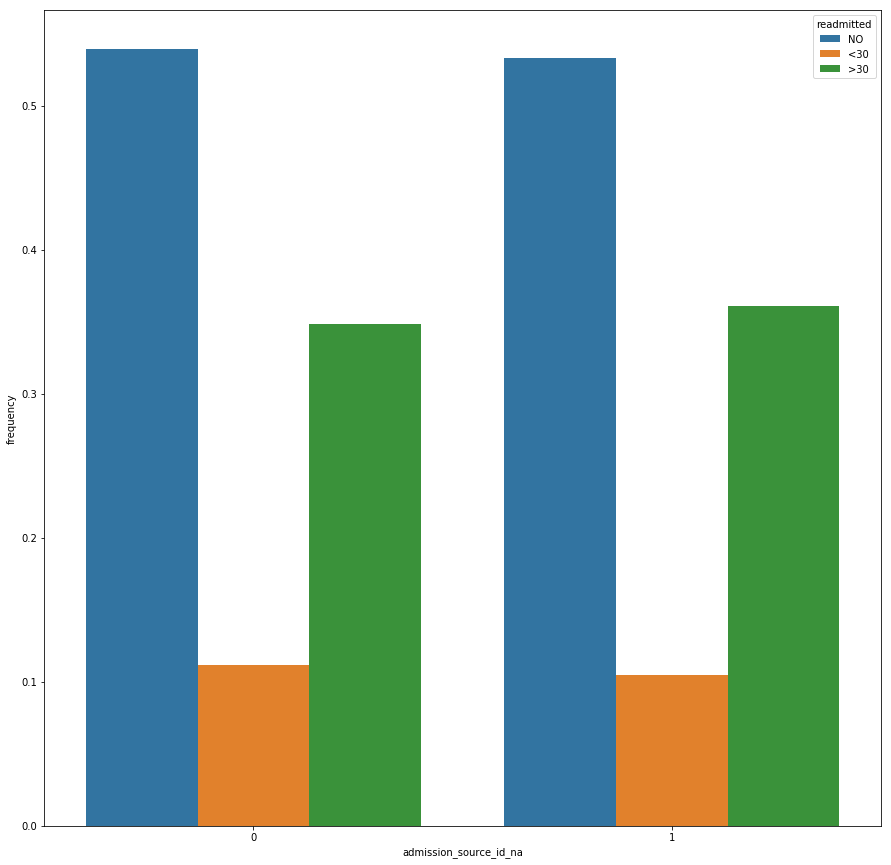

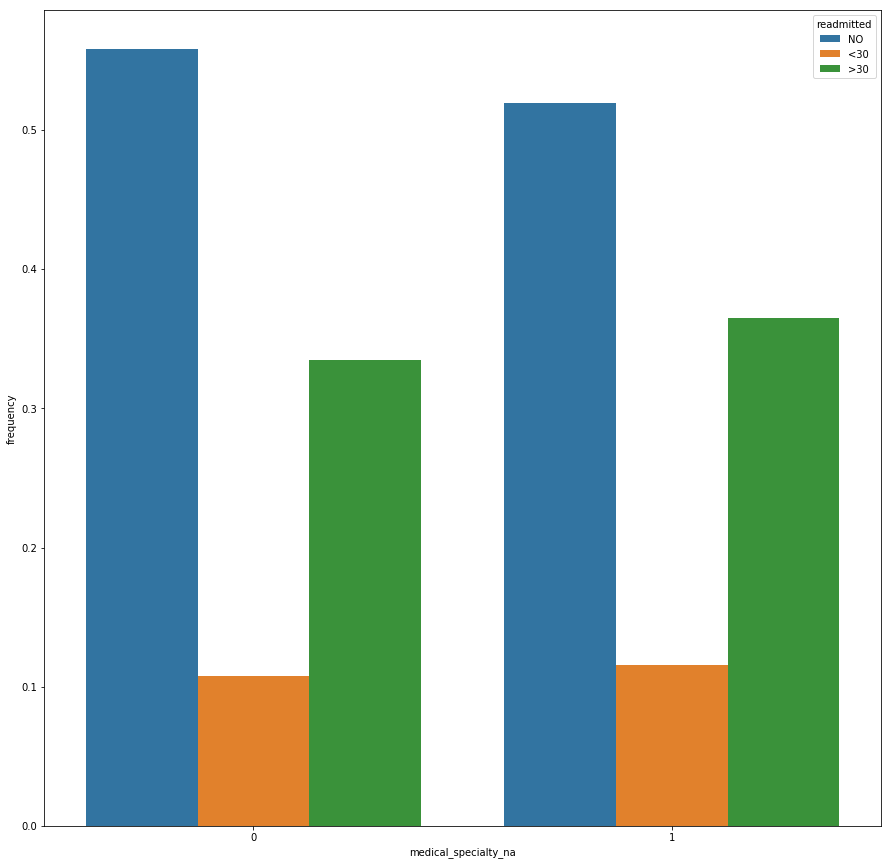

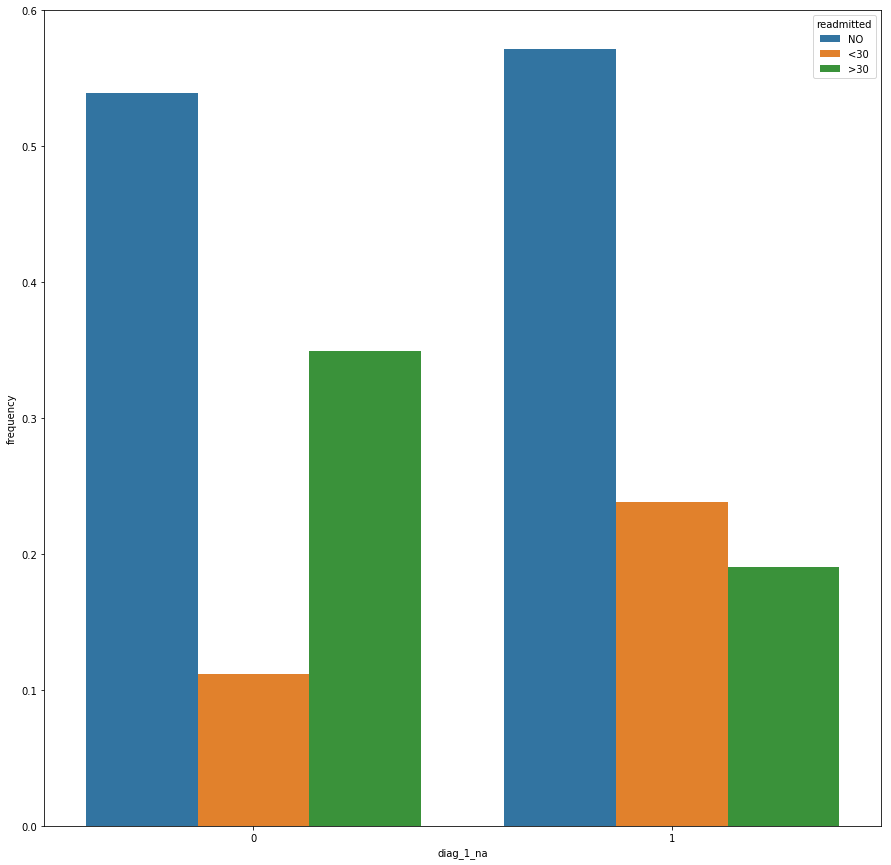

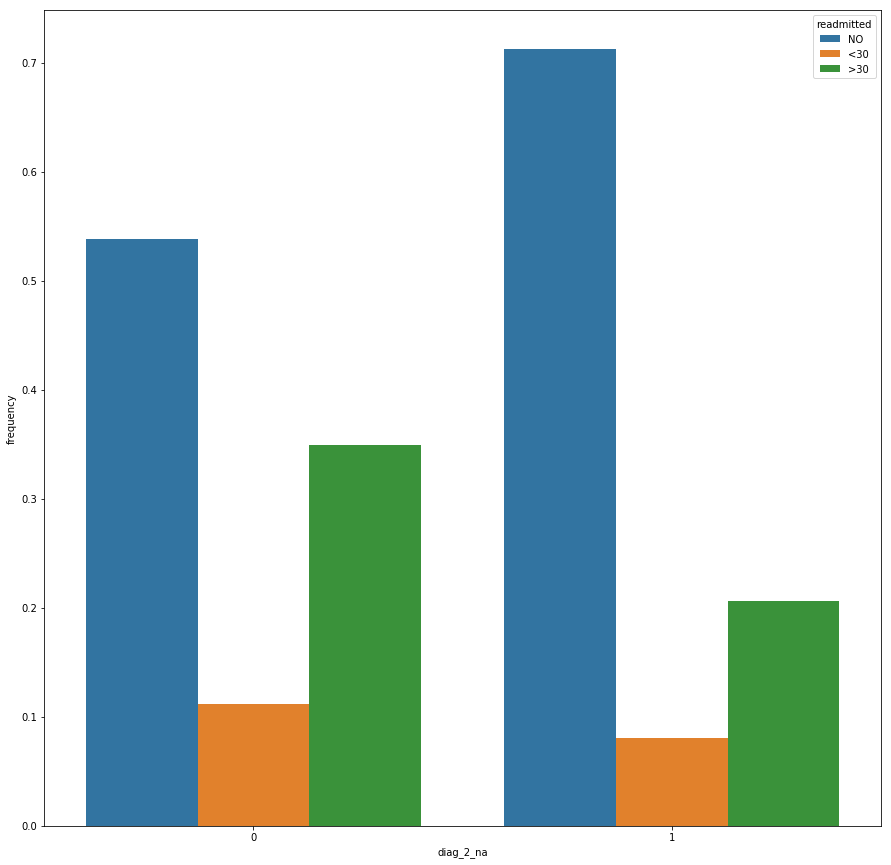

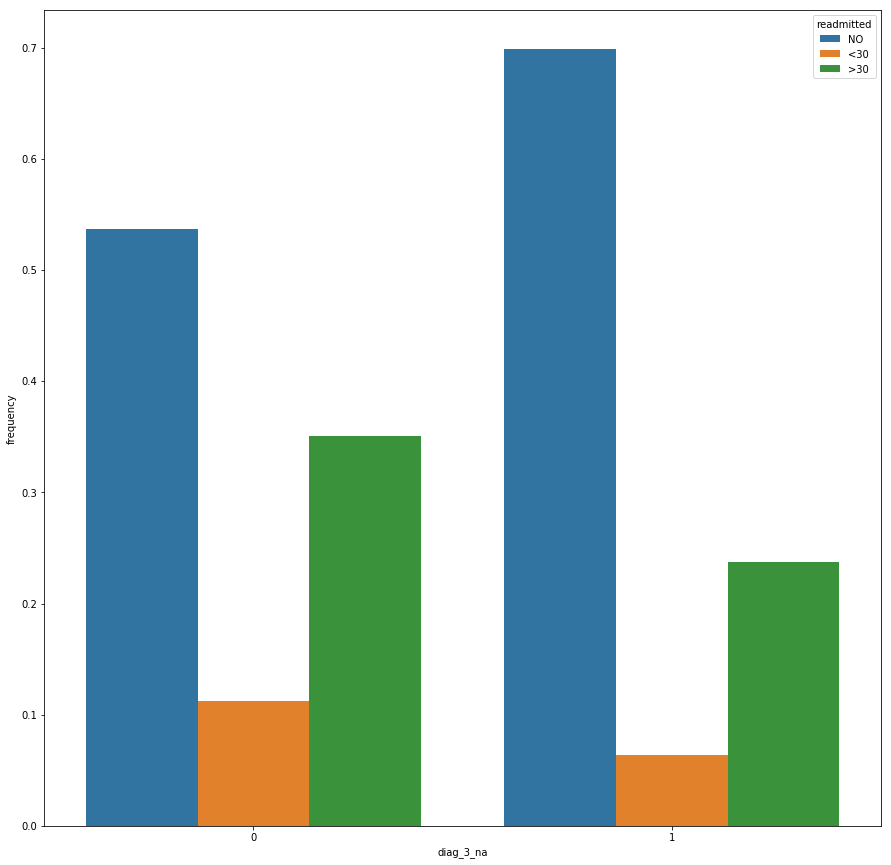

In [10]:
for x_column in x_columns:
    plt.figure(figsize=(15, 15))
    sns.barplot(x = x_column, y='frequency', hue='readmitted', 
                data=frequencies_by_groups(df, [x_column, 'readmitted'], df_labels))
    plt.show()

In [11]:
by_diag1 = frequencies_by_groups(df, ['diag_1', 'readmitted'], df_labels)
by_diag1.head()

,diag_1,readmitted,value_count,sum_by_diag_1,frequency
0,NaN,NO,12,21,0.571429
1,NaN,<30,5,21,0.238095
2,NaN,>30,4,21,0.190476
3,10,NO,1,1,1.000000
4,11,NO,7,10,0.700000


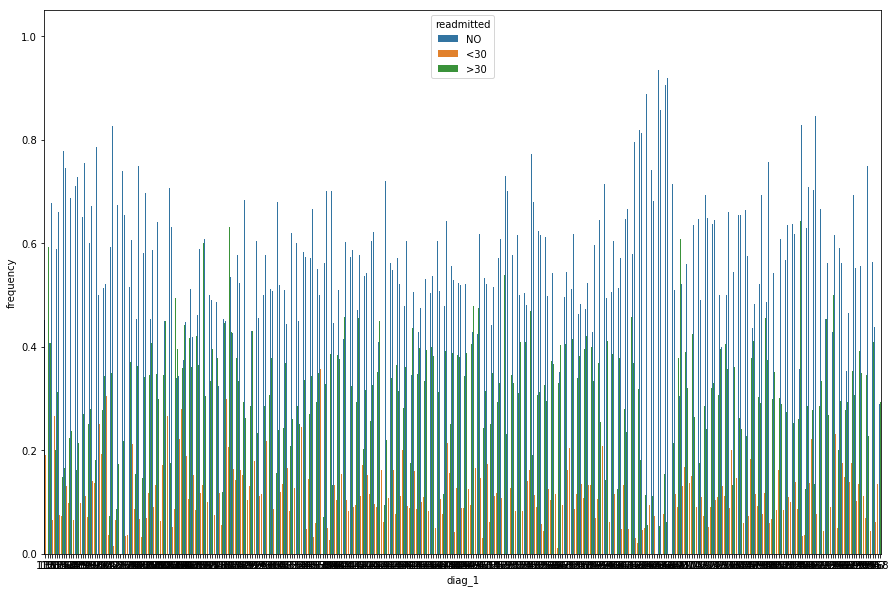

In [12]:
plt.figure(figsize=(15, 10))
sns.barplot(x = 'diag_1', y='frequency', hue='readmitted', data=by_diag1.loc[by_diag1.sum_by_diag_1 > 12, ['diag_1', 'readmitted', 'frequency']])

In [13]:
by_diag1_box = by_diag1.loc[by_diag1.sum_by_diag_1 > 12, :]
by_diag1_box = by_diag1_box.pivot(index='diag_1', columns='readmitted', values='frequency')
by_diag1_box.head()

readmitted,<30,>30,NO
diag_1,,,
NaN,0.238095,0.190476,0.571429
112,0.191781,0.356164,0.452055
135,NaN,0.592593,0.407407
150,0.185185,0.407407,0.407407
151,0.064516,0.258065,0.677419


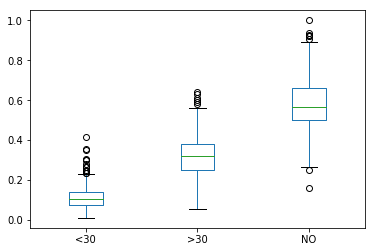

In [14]:
by_diag1_box.plot.box()

In [15]:
tree = ICD9('icd9/codes.json')
def simplify_codes(codes):
    """Takes a series of codes, simplifies and pads them with zeros to be useful for searching in ICD9 database
    Args:
        codes: a Series of ICD9 codes in extended format
    Returns:
        List containing simplified and padded ICD9 codes. The order corresponds to the codes in the argument.
    """
    pat = '^([EV]?\\d\\d?\\d?\\.?\\d?).?'
    short_pat = '^(\\d*)'
    simple_codes = [re.search(pat, code).group(1) if type(code) == str else np.nan for code in codes]
    simple_codes_padded = [('0' * (3 - len(re.search(short_pat , code).group(1))) + code) if (type(code)==str and bool(re.search(short_pat , code).group())) else code for code in simple_codes]
    return simple_codes_padded

def find_description(code):
    try:
        int(code)
        if int(code) in range(910, 920):
            return tree.find('905').description
        elif int(code) == 235:
            return tree.find('236').description
        elif int(code) == 752:
            return tree.find('751').description
        else:
            return tree.find(code).description
    except ValueError:
       return tree.find(code).description

In [16]:
top_diag1_readmitted_shortly = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == '<30',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_readmitted_shortly['description'] = [find_description(code) for code in simplify_codes(top_diag1_readmitted_shortly.diag_1)]
top_diag1_readmitted_shortly[['diag_1', 'frequency', 'value_count', 'description']]

,diag_1,frequency,value_count,description
1684,V58,0.416667,95,Encounter for other and unspecified procedures...
274,250.41,0.263736,24,Diabetes with renal manifestations
970,567,0.245614,14,Peritonitis and retroperitoneal infections
277,250.42,0.222222,20,Diabetes with renal manifestations
415,298,0.218750,14,Other nonorganic psychoses
716,443,0.218182,24,Other peripheral vascular disease
1038,593,0.207921,21,Other disorders of kidney and ureter
367,282,0.205882,14,Hereditary hemolytic anemias
986,572,0.205021,49,Liver abscess and sequelae of chronic liver di...
704,438,0.200000,17,Late effects of cerebrovascular disease


In [17]:
top_diag1_readmitted_longer = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == '>30',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_readmitted_longer['description'] = [tree.find(code).description for code in simplify_codes(top_diag1_readmitted_longer.diag_1)]
top_diag1_readmitted_longer[['frequency', 'value_count', 'description']]

,frequency,value_count,description
368,0.632353,43,Hereditary hemolytic anemias
1190,0.608696,14,Dermatitis due to substances taken internally
18,0.592593,16,Sarcoidosis
826,0.583333,14,Bronchiectasis
354,0.558824,19,Other and unspecified disorders of metabolism
878,0.538462,14,Diseases of pulp and periapical tissues
1552,0.527273,29,Contusion of lower limb and of other and unspe...
1527,0.500000,23,Ill-defined intestinal infections
272,0.494382,132,Diabetes with renal manifestations
823,0.479167,506,Asthma


In [18]:
top_diag1_not_readmitted = by_diag1.loc[np.logical_and(
    by_diag1.readmitted == 'NO',
    by_diag1.value_count>12), :].sort_values('frequency', ascending=False).head(20)
top_diag1_not_readmitted['description'] = [find_description(code) for code in simplify_codes(top_diag1_not_readmitted.diag_1)]
top_diag1_not_readmitted[['frequency', 'value_count', 'description']]

,frequency,value_count,description
1162,1.000000,20,Trauma to perineum and vulva during delivery
1140,0.934783,86,Abnormality of organs and soft tissues of pelvis
570,0.928571,13,Strabismus and other disorders of binocular ey...
1158,0.920000,23,Abnormality of forces of labor
1150,0.906250,29,Other indications for care or intervention rel...
195,0.888889,24,Neoplasm of uncertain behavior of genitourinar...
1106,0.888889,16,Menopausal and postmenopausal disorders
149,0.888889,24,Myeloid leukemia
1057,0.875000,14,Inflammatory diseases of prostate
1144,0.857143,18,Other known or suspected fetal and placental p...


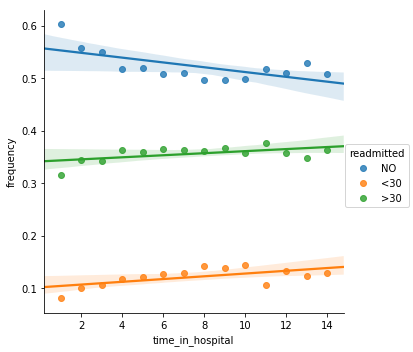

In [19]:
by_time_in_hospital = frequencies_by_groups(df, ['time_in_hospital', 'readmitted'], df_labels)
sns.lmplot(x='time_in_hospital', y='frequency', hue='readmitted', data=by_time_in_hospital)

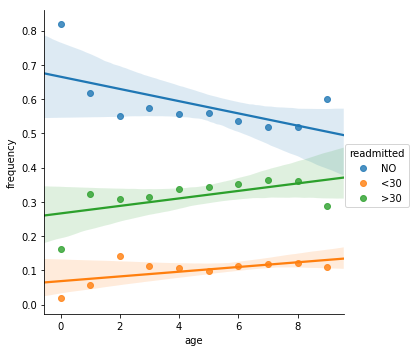

In [20]:
by_age = frequencies_by_groups(df, ['age', 'readmitted'], df_labels)
age_cat_type = CategoricalDtype(categories=['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', 
                                                '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'],
                                ordered=True)
by_age.age = by_age.age.astype(age_cat_type)
by_age['age'] = by_age.age.cat.codes
sns.lmplot(x='age', y='frequency', hue='readmitted', data=by_age)

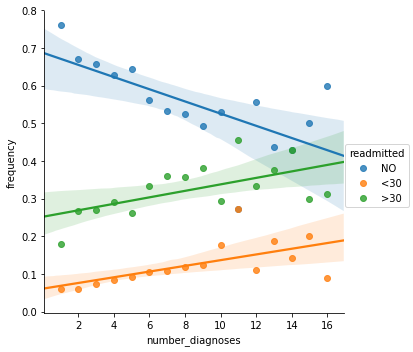

In [21]:
by_number_diagnoses = frequencies_by_groups(df, ['number_diagnoses', 'readmitted'], df_labels)
sns.lmplot(x='number_diagnoses', y='frequency', hue='readmitted', data=by_number_diagnoses)

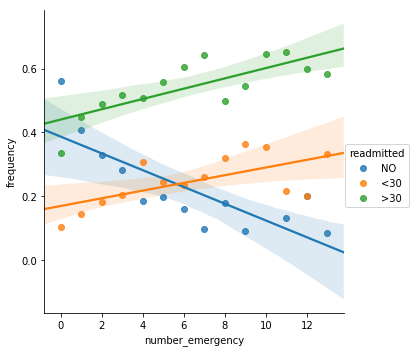

In [22]:
by_number_emergency = frequencies_by_groups(df, ['number_emergency', 'readmitted'], df_labels)
sns.lmplot(x='number_emergency', y='frequency', hue='readmitted', data=by_number_emergency.loc[by_number_emergency.number_emergency < 14])

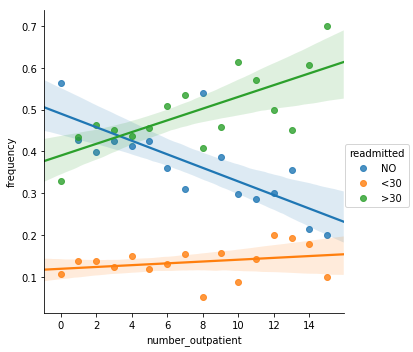

In [23]:
by_number_outpatient = frequencies_by_groups(df, ['number_outpatient', 'readmitted'], df_labels)
sns.lmplot(x='number_outpatient', y='frequency', hue='readmitted', data=by_number_outpatient.loc[by_number_outpatient.number_outpatient < 16])

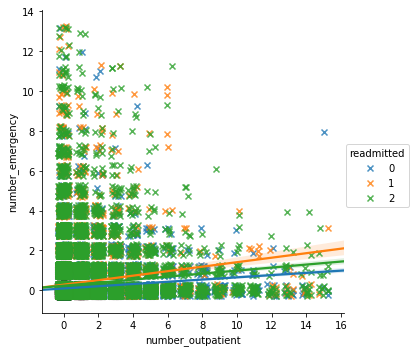

In [24]:
filtered_df = df.loc[(df.number_outpatient < 16) & (df.number_emergency < 14)]
sns.lmplot(x='number_outpatient', y='number_emergency', data=filtered_df, x_jitter=.3, y_jitter=.3, markers='x', hue='readmitted')

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


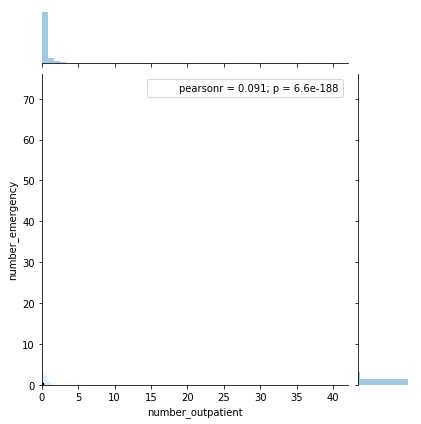

In [25]:
sns.jointplot(df.number_outpatient, df.number_emergency, kind="hex")

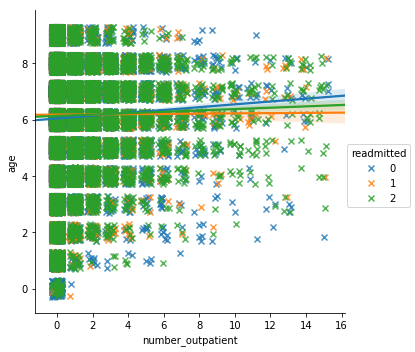

In [26]:
filtered_df = df.loc[df.number_outpatient < 16]
sns.lmplot(x='number_outpatient', y='age', data=filtered_df, x_jitter=.3, y_jitter=.3, markers='x', hue='readmitted')

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


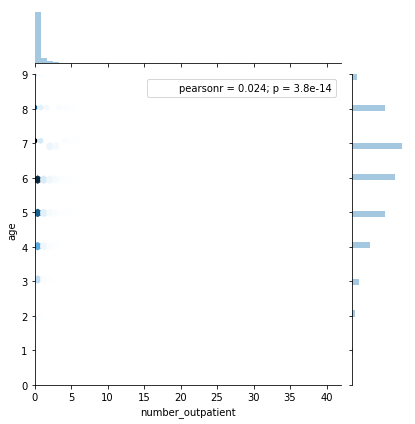

In [27]:
sns.jointplot(df.number_outpatient, df.age, kind="hex")

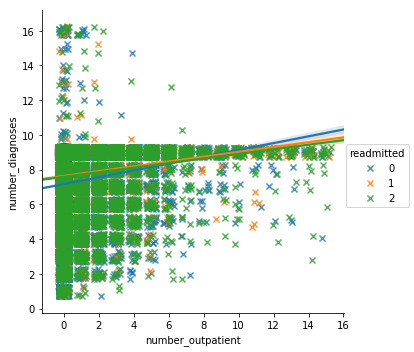

In [28]:
filtered_df = df.loc[df.number_outpatient < 16]
sns.lmplot(x='number_outpatient', y='number_diagnoses', data=filtered_df, x_jitter=.3, y_jitter=.3, markers='x', hue='readmitted')

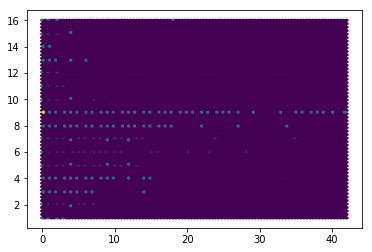

In [29]:
plt.hexbin(df.number_outpatient, df.number_diagnoses, bins=4)

/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/pavel/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


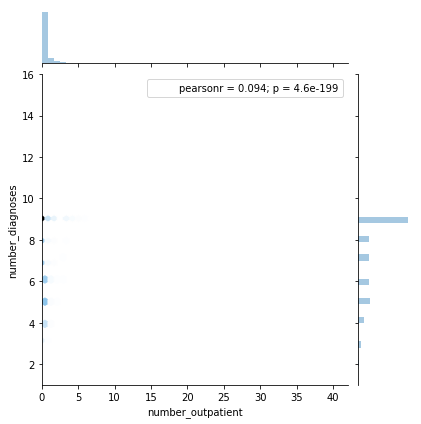

In [30]:
sns.jointplot(df.number_outpatient, df.number_diagnoses, kind="hex")